# Milestone 1 - Pemilihan Topik Riset

Digital Talent Scholarship 2018, Kelas A-BIG DATA - Universitas Gadjah Mada

Anggota:

1. Luthfi Zharif

2. Larasati Aisyah R. A.

3. Karyadi

4. Izzan Rijal

5. Ismul Aksan

Kelompok kami mengeksplorasi aktivitas perusahaan rintisan, atau yang biasa dikenal dengan startup menggunakan dataset berita dari [GDELT](https://www.gdeltproject.org/). Proyek ini akan terus kami perbaiki selama beberapa waktu kedepan.
Laporan ini akan terbagi menjadi beberapa bagian, yaitu pendahuluan, ekstraksi data, transformasi data, dan analisis.

## Pendahuluan

Saat ini, dunia industri sedang memasuki babak baru yaitu revolusi industri keempat yang ditandai dengan perkembangan teknologi yang sangat cepat serta peran teknologi dan informasi yang dominan dalam kehidupan manusia. Perkembangan teknologi berubah pada jangka waktu yang tidak terlalu lama.  Perubahan teknologi ini menyebabkan adanya disrupsi yang saat ini sudah tercermin dengan banyaknya start up atau perusahaan rintisan.  

Startup dapat didefinisikan sebagai perusahaan yang bisnisnya baru yang berkembang pesat dan bertujuan untuk memenuhi kebutuhan pasar dengan mengembangkan atau menawarkan produk, proses, atau layanan yang inovatif secara cepat. Perusahaan rintisan atau start up menerapkan berbagai teknologi seperti internet, e-commerce, komputer, telekomunikasi atau robotik. Pada umumnya, start up berperan dalam membuat dan mengimplementasikan proses inovasi sejak pengembangan, validasi, dan research untuk target pasarnya.

Saat ini, banyak Startup mulai bermunculan di dunia, termasuk di Indonesia. Perusahaan ini berkembang dengan cepat dan memberikan perubahan perilaku masyarakat. Masyarakat yang awalnya menggunakan ojek pangkalan berpindah ke ojek online dengan segala fitur yang ada. Masyarakat yang tadinya berbelanja di mall kini belanja di toko online yang memberikan layanan antar sampai ke rumah.

Salah satu penyebab tumbuh subur startup di Indonesia ialah banyaknya pengguna internet. Dari hasil survei Asosiasi Penyelenggara Jasa Internet Indonesia (APJII), pada tahun 2016 ada 132,7 juta pengguna internet dari total 256,2 juta penduduk Indonesia. Apabila dikelompokkan berdasarkan perangkat yang dipakai ada kelompok yakni mobile phone (63.1 juta pengguna atau 47 %), mobile dan komputer (50.7 juta pengguna atau 51%) serta computer (2,2 juta pengguna atau 2%). Ini merupakan pangsa pasar yang cukup besar, dan memungkinkan perkembangan start up.

Unicorn di dunia startup adalah perusahaan startup yang memiliki nilai pasar lebih dari US$1 miliar. Istilah ini pertama kali digunakan oleh venture capitalist, Aileen Lee, dimana dia memilih kuda bertanduk satu ini untuk mewakili kelangkaan statistik dari usaha-usaha startup. Di Negara lain, seperti Tiongkok, saat ini sudah terdapat 46 perusahaan startup yang masuk dalam kategori Unicorn. Di Indonesia terdapat 4 perusahaan startup yang sudah masuk kategori Unicorn, yakni Bukalapak, Gojek, Tokopedia dan Traveloka. 

Melihat perkembangan startup Indonesia yang cukup dinamis kami tertarik untuk mengetahui bagaimana perkembangan startup Indonesia di mata dunia melalui gdelt. 


## Ekstraksi Data
### Download

Data ini bisa diolah dengan dua cara, yakni melalui olah secara cloud maupun local. Dalam notebook ini, semua pengolahan akan dilakukan secara local. Oleh karena itu, kita perlu mengunduh data GDELT ke dalam mesin lokal terlebih dahulu.

Berikut adalah contoh script untuk mengunduh data GDELT dengan country code 'ID'. Country code ini menandakan bahwa kita hanya menyimpan data yang berhubungan dengan Indonesia. Source code ini disadur dari [Github pak Guntur Budi](https://github.com/gunturbudi/digital-talent/blob/master/RETRIEVE%20GDELT%20DATA.ipynb)

In [ ]:
import requests
import lxml.html as lh

gdelt_base_url = 'http://data.gdeltproject.org/events/'

# get the list of all the links on the gdelt file page
page = requests.get(gdelt_base_url+'index.html')
doc = lh.fromstring(page.content)
link_list = doc.xpath("//*/ul/li/a/@href")

# separate out those links that begin with four digits
file_list = [x for x in link_list if str.isdigit(x[0:4])]
print(file_list)

infilecounter = 0
outfilecounter = 0

import os.path
import urllib
import zipfile
import glob
import operator

local_path = os.getcwd()

fips_country_code = 'ID'

for compressed_file in file_list[infilecounter:]:
    print(compressed_file)

    # if we dont have the compressed file stored locally, go get it. 
    # Keep trying if necessary.
    while not os.path.isfile(local_path + compressed_file):
        print('downloading, '),
        urllib.request.urlretrieve(url=gdelt_base_url + compressed_file,
                           filename=local_path + compressed_file)

    # extract the contents of the compressed file to a temporary directory
    print('extracting,'),
    z = zipfile.ZipFile(file=local_path + compressed_file, mode='r')
    z.extractall(path=local_path + 'tmp/')

    # parse each of the csv files in the working directory,
    print('parsing,'),
    for infile_name in glob.glob(local_path + 'tmp/*'):
        outfile_name = local_path + 'gdelt_id/' + fips_country_code 
        + '%04i.tsv' % outfilecounter

        # open the infile and outfile
        with open(infile_name, mode='r', encoding='utf-8') as infile,
        open(outfile_name, mode='w') as outfile:
            for line in infile:
                # extract lines with our interest country code
                # Try and except to pass trouble data
                try:
                    # We extract only the lines where there is relation 
                    # about Indonesia (ID)
                    if fips_country_code in operator.
                    itemgetter(51, 37, 44)(line.split('\t')):
                        outfile.write(line)
                except:
                    pass
            outfilecounter += 1
        # delete the temporary file
        os.remove(infile_name)
    infilecounter += 1
    print('done')

### Simpan ke MySQL
Perlu dilakukan penyimpanan data ke dalam database MySQL agar data bisa diakses secara local. Adapun langkah yang
dilakukan adalah sebagai berikut

#### Bangun koneksi ke MySQL lokal
Silakan buka phpMyAdmin atau program SQL favorit anda (HeidiSQL, Laragon), lalu buat database dengan nama 'gdelt_content_id'

In [1]:
import pymysql
import pandas as pd
from sqlalchemy import create_engine

host = 'localhost'
port = '3306'
username = 'root'
password = ''
database = 'gdelt_content_id'

# Create Connection to database
# engine = create_engine('mysql+pymysql://'+username+
# ':'+password+'@'+host+':'+port+'/'+database)

# Note: We use pymysql instead of sqlalchemy because sqlalchemy
# somehow don't allow the text query. Strange bug.
conn = pymysql.connect(
    host=host,
    port=int(port),
    user=username,
    passwd=password,
    db=database,
    charset='utf8mb4')
'''engine = create_engine('mysql+pymysql://root: @localhost:3306
/gdelt_content_id')'''

def run(sql):
    df = pd.read_sql_query(sql, conn)
    return df

#### List Data dalam Folder
Di bagian ini, kita akan membaca data GDELT harian (tsv) dalam folder. Data tersebut akan dikompilasi menjadi dataframe Pandas.

In [ ]:
from os import listdir
from os.path import isfile, join
folder_id = './gdelt_id/'
files = [f for f in listdir(folder_id) if isfile(join(folder_id, f))]
print(files)

In [ ]:
# Open first file for sanity check
df_awal = pd.read_csv(folder_id + files[0],sep="\t")
df_awal.head()

#### Langsung simpan ke MySQL
Untuk menyimpan data ke SQL, kita update data tabelnya untuk setiap file tsv yang ada

In [ ]:
# Read header / column names
colnames = list(pd.read_excel('CSV.header.fieldids.xlsx', 
                              sheet_name='CSV.header.dailyupdates'))

for berkas in files:
    print('Extracting ' + berkas)
    df_satuan = pd.DataFrame()
    
    # Important: If your ID0000.tsv contains header, you can delete the header
    df_satuan = pd.read_csv(folder_id + berkas, sep="\t", names= colnames)
    df_satuan.to_sql(name = database, con = engine, 
                     if_exists = 'append', index = False)

## Transformasi Data

### Cek Data Awal
Setelah data tersimpan secara sukses di MySQL, kita melakukan eksplorasi sederhana. Langkah pertama yang perlu dilakukan adalah melakukan filter artikel yang sesuai dengan topik startup. Dengan asumsi judul berita dimuat dalam URL artikel, maka dilakukan  filter kolom 'SOURCEURL' dengan menggunakan kata kunci yang berhubungan dengan topik startup. Sejauh ini ada beberapa kata kunci adalah sebagai berikut:

- Startup

- Start-up

- Unicorn

- Silicon-valley

- Ecommerce

- E-commerce

- Rintisan

- Perusahaan-rintisan

- Perusahaan-startup

- Bisnis-startup

- Startup-business

- Startup-digital

- Digital-startup

- Crowdfunding

- Fintech

- Marketplace

- Digital-platform

- Platform-digital


In [2]:
# SQL query to look for keyword in SOURCEURL
data_startup = run("""
SELECT 
    * 
FROM 
    gdelt_content_id
WHERE
    sourceurl LIKE '%startup%' OR
    sourceurl LIKE '%unicorn%' OR
    sourceurl LIKE '%start-up%' OR
    sourceurl LIKE '%silicon-valley%' OR
    sourceurl LIKE '%ecommerce%' OR
    sourceurl LIKE '%e-commerce%' OR
    sourceurl LIKE '%rintisan%' OR
    sourceurl LIKE '%perusahaan-rintisan%' OR
    sourceurl LIKE '%perusahaan-startup%' OR
    sourceurl LIKE '%bisnis-startup%' OR
    sourceurl LIKE '%startup-business%' OR
    sourceurl LIKE '%startup-digital%' OR
    sourceurl LIKE '%digital-startup%' OR
    sourceurl LIKE '%crowdfunding%' OR
    sourceurl LIKE '%fintech%' OR
    sourceurl LIKE '%marketplace%' OR
    sourceurl LIKE '%digital-platform%' OR
    sourceurl LIKE '%platform-digital%'
    """)

In [3]:
print(data_startup.shape)
data_startup.head()

(6408, 58)


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,798274953,20181029,201810,2018,2018.8192,GOV,GOVERNMENT,None,None,None,...,None,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
1,798275016,20181029,201810,2018,2018.8192,GOV,GOVERNMENT,None,None,None,...,10175966,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
2,798275087,20181029,201810,2018,2018.8192,IDN,INDONESIA,IDN,None,None,...,None,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
3,798275096,20181029,201810,2018,2018.8192,IDNBUS,INDONESIA,IDN,None,None,...,10175966,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
4,798359666,20181029,201810,2018,2018.8192,BUS,COMPANY,None,None,None,...,None,1,Indonesia,ID,ID,-5.0000,120.000,ID,20181029.0,https://www.dealstreetasia.com/stories/indones...


Berdasarkan hasil di atas, terdapat beberapa data duplikat, yang dapat dilihat dari kolom 'SOURCEURL'. Data duplikat ini 
diduga memiliki informasi yang berbeda pada kolom-kolom lainnya, seperti Actor1Name, Actor2Name, dll.

Untuk saat ini, kita memfokuskan hasil dengan menghapus data duplikat.

In [4]:
data_startup_dup = data_startup.copy()

# Remove duplicate data, keep the first occurences
data_startup = data_startup.drop_duplicates('SOURCEURL')
data_startup.shape

(2217, 58)

Dengan menghapus data duplikat diperoleh 2217 baris berita yang unik, jumlah tersebut hampir 1/3 bagian dari data sebelumnya. Selanjutnya, data tersebut disimpan ke dalam MySQL. Namun, data sebelumnya tetap disimpan untuk analisis selanjutnya.

In [5]:
# Save non-duplicated data to 'startup_indonesia' table
host = 'localhost'
port = '3306'
username = 'root'
password = ''
database = 'gdelt_content_id'
database_name = 'startup_indonesia'
engine_s = create_engine('mysql+pymysql://'+username+':'+password+'@'+host+':'
                         +port+'/'+database)
data_startup.to_sql(database_name, engine_s)

# Save duplicated data to 'startup_indonesia_dup' table
database = 'gdelt_content_id'
database_name_dup = 'startup_indonesia_dup'
data_startup_dup.to_sql(database_name_dup, engine_s)

Untuk analisis selanjutnya, kita akan menggunakan data lima tahun terakhir saja, terhitung dari 2014 - Oktober 2018.

In [2]:
data_5years = run("""
SELECT 
    * 
FROM 
    startup_indonesia 
WHERE 
    Year BETWEEN 2014 AND 2018
""")
data_5years.head()

,index,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,0,798274953,20181029,201810,2018,2018.8192,GOV,GOVERNMENT,None,None,...,None,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.14580,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
1,4,798359666,20181029,201810,2018,2018.8192,BUS,COMPANY,None,None,...,None,1,Indonesia,ID,ID,-5.00000,120.000,ID,20181029.0,https://www.dealstreetasia.com/stories/indones...
2,5,797650072,20181026,201810,2018,2018.8110,GOV,FINANCE MINIST,None,None,...,-2679652,4,"Jakarta, Jakarta Raya, Indonesia",ID,ID04,-6.17444,106.829,-2679652,20181026.0,http://www.thejakartapost.com/news/2018/10/26/...
3,6,797801179,20181026,201810,2018,2018.8110,MED,PUBLISHER,None,None,...,None,1,Indonesia,ID,ID,-5.00000,120.000,ID,20181026.0,https://www.mediapost.com/publications/article...
4,7,797376646,20181025,201810,2018,2018.8082,MOS,MUSLIM,None,None,...,ID,1,Indonesia,ID,ID,-5.00000,120.000,ID,20181025.0,https://www.dealstreetasia.com/stories/indones...


## Analisis Data
Dengan data yang sudah unik tersebut, kita memulai analisis berita sesuai dengan kebutuhan. 

### Analisis sumber berita
Di bagian ini, akan ditampilkan website yang menjadi sumber berita.

In [4]:
import urllib

data_sourceurl = data_5years['SOURCEURL']
list_link = []

# for extracting domain url. Example: 
# http://fintechnews.sg/25313/blockchain/blockchain-indonesia/ --> fintechnews.sg
for link in data_sourceurl:
    list_link.append(urllib.parse.urlparse(link).netloc)
    
data_link = pd.Series(list_link)

# Count by its occurences
data_link_count = data_link.value_counts()
data_link_count

www.techinasia.com                163
www.dealstreetasia.com            158
www.thejakartapost.com            140
e27.co                             91
en.tempo.co                        63
fintechnews.sg                     44
sglinks.com                        35
www.ecosystemmarketplace.com       34
www.techinasia.com:443             33
ecommerce-journal.com              33
inc42.com                          33
www.crowdfundinsider.com           31
economictimes.indiatimes.com       28
jakartaglobe.beritasatu.com        27
www.nationmultimedia.com           25
sg.news.yahoo.com                  23
asia.nikkei.com                    22
www.thestar.com.my                 18
jakartaglobe.id                    17
www.digitalnewsasia.com            17
techcrunch.com                     16
www.businesstimes.com.sg           16
www.straitstimes.com               16
www.bloomberg.com                  16
www.forbes.com                     15
www.msn.com                        14
www.indonesi

Dari data di atas, diketahui pemberitaan startup di Indonesia banyak dilakukan oleh techinasia.com, dealstreetasia.com, dan thejakartapost.com.

### Analisis Tren Startup Berdasarkan Waktu
Dalam bagian ini, akan ditampilkan banyaknya berita startup dalam hitungan bulan. Analisis ini berguna untuk melihat kapan pemberitaan banyak bermunculan, serta melihat apakah ada peningkatan atau penurunan pemberitaan startup di Indonesia.

In [5]:
data_count = data_5years.copy()
# data_count['MonthYear'] = pd.to_datetime(data_count['MonthYear']
# .astype(str), format='%Y%m')

# Aggregate the table with count
data_count = data_count.groupby(data_count['MonthYear']).agg({'count'})
data_count = data_count.sort_index(ascending=True)
data_count['GLOBALEVENTID'].head()

,count
MonthYear,
201401,3
201402,14
201403,15
201404,15
201405,7


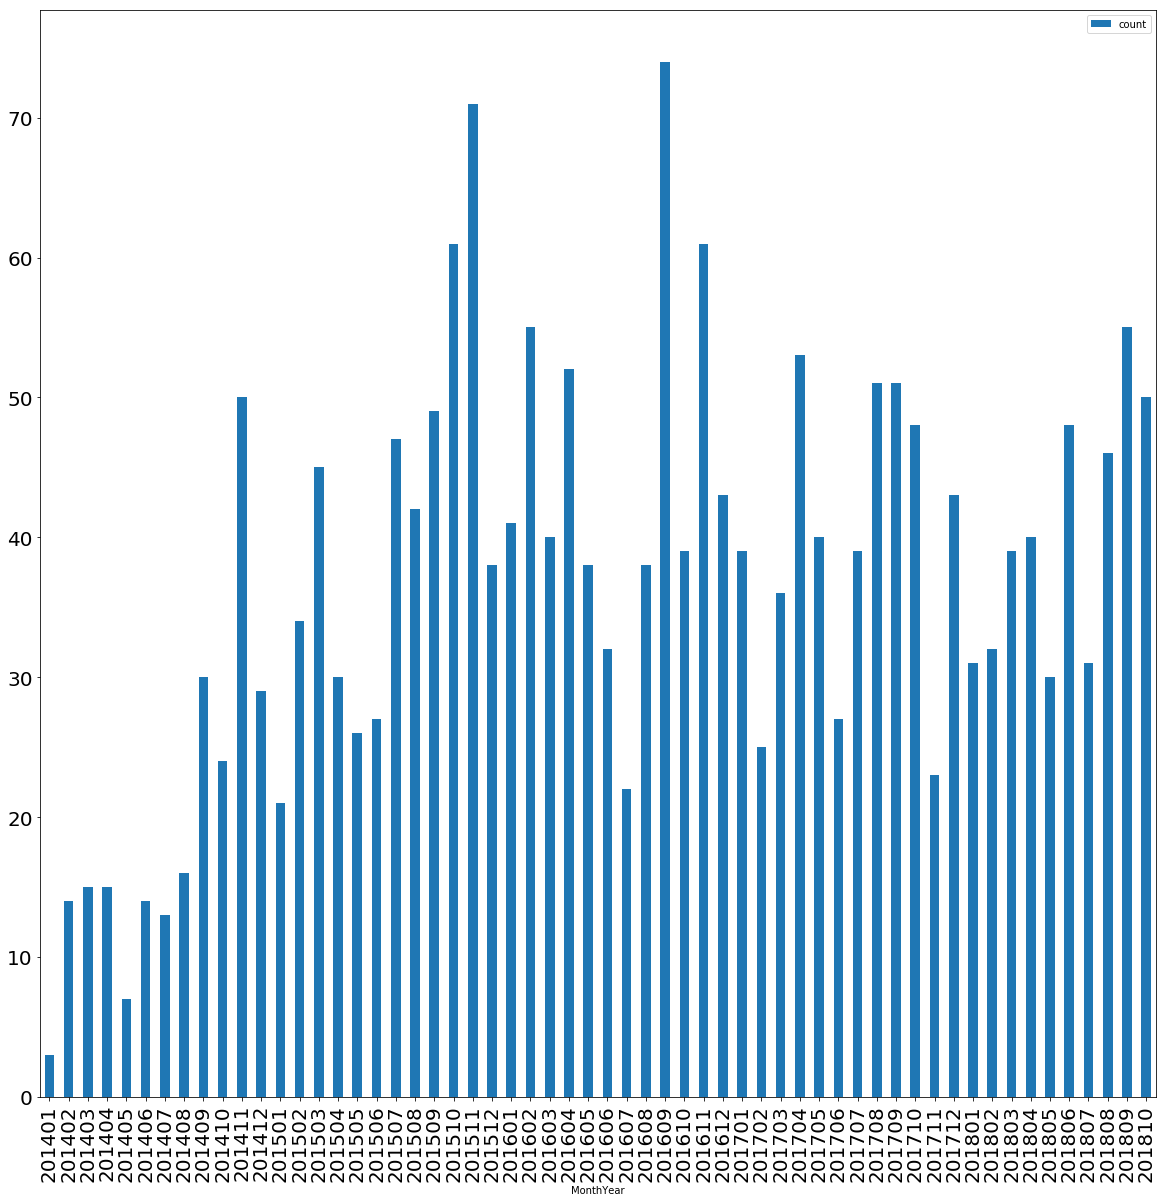

In [7]:
# display it using bar
data_count['GLOBALEVENTID'].plot(kind='bar', figsize=(20,20), fontsize=20)

Berdasarkan grafik diatas, terlihat bahwa pemberitaan startup di Indonesia masih mengalami fluktuasi pada 5 tahun terakhir. Tren kenaikan terlihat pada periode 2012-2014. Berita startup di Indonesia mulai sering bermunculan sejak November 2014.

# Milestone 2 - Analisis Statistika
Dalam analisis ini, kita akan coba melihat data GDELT dengan perspektif Statistika Inferensial. Ada beberapa variabel menarik yang bisa kita olah, diantaranya:
- Actor 1 & 2
- Goldstein Scale
- Number of Mention, Sources, and Article
- Average Tone

## Actor 1 & Actor 2

Actor 1 dan Actor 2 dalam GDELT menunjukkan pihak yang memberikan dampak sebuah event/kejadian/berita (Actor 1) dan pihak yang diberikan dampak sebuah event/kejadian/berita (Actor 2). Terdapat beberapa objek yang akan dianalisis mengenai Actor 1 dan Actor 2, yaitu dari Actor Code, Actor Country Code, dan Actor Names.

In [3]:
data_5yearsdup = run("""
SELECT 
    * 
FROM 
    startup_indonesia_dup 
WHERE 
    Year BETWEEN 2014 AND 2018
""")
data_5yearsdup.head()

,index,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,0,798274953,20181029,201810,2018,2018.8192,GOV,GOVERNMENT,None,None,...,None,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
1,1,798275016,20181029,201810,2018,2018.8192,GOV,GOVERNMENT,None,None,...,10175966,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
2,2,798275087,20181029,201810,2018,2018.8192,IDN,INDONESIA,IDN,None,...,None,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
3,3,798275096,20181029,201810,2018,2018.8192,IDNBUS,INDONESIA,IDN,None,...,10175966,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
4,4,798359666,20181029,201810,2018,2018.8192,BUS,COMPANY,None,None,...,None,1,Indonesia,ID,ID,-5.0000,120.000,ID,20181029.0,https://www.dealstreetasia.com/stories/indones...


#### Actor Code

Merupakan code pada CAMEO yang merupakan kode mentah lengkap untuk Actor1 dan Actor2 (termasuk kelas geografis, kelas, etnis, agama, dan jenis). Kode akan kosong jika sistem tidak dapat mengidentifikasi pihak yang menjadi Actor1 dan Actor2.

In [12]:
# Mencari jumlah Actor1 Code yang paling banyak muncul
data_code1 = data_5yearsdup['Actor1Code']
data_code1.value_counts()
data_code1.describe()

count     5651
unique     205
top        IDN
freq      1771
Name: Actor1Code, dtype: object

Text(0,0.5,'Jumlah Event')

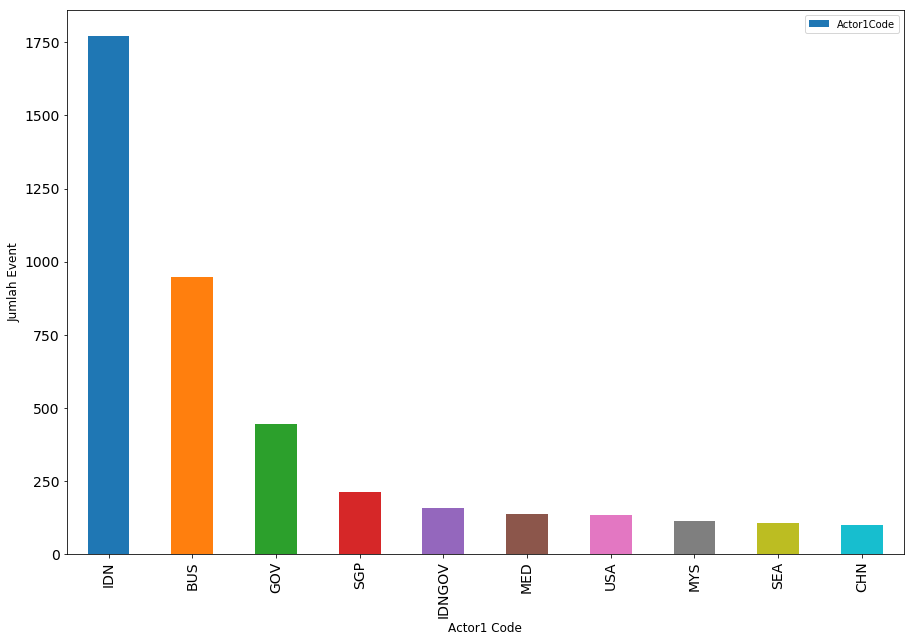

In [13]:
plt.figure(figsize=(15,10))
ax = data_code1.value_counts().head(10)
ax = ax.plot(kind='bar', title ="", legend=True, fontsize=14)
ax.set_xlabel("Actor1 Code", fontsize=12)
ax.set_ylabel("Jumlah Event", fontsize=12)

Grafik di atas menunjukkan bahwa Actor1 atau pihak yang memberikan dampak dalam event/berita paling banyak adalah Indonesia (IDN) dengan jumlah 1771 event/berita. Actor1 lainnya yang banyak muncul antara lain adalah BUS (Business), GOV (Pemerintah), SGP (Singapura), dan IDNGOV (Pemerintah Indonesia). Actor1 Code menunjukkan pihak yang memberikan dampak tetapi tidak dapat diketahui asal negara tersebut karena Actor1 Code berisi Kode dari berbagai kelas geografis, kelas, etnis, agama, dan jenis.

In [15]:
data_code2 = data_5yearsdup['Actor2Code']
data_code2
data_code2.value_counts()
data_code2.describe()

count     4424
unique     187
top        IDN
freq      1242
Name: Actor2Code, dtype: object

Text(0,0.5,'Jumlah Berita')

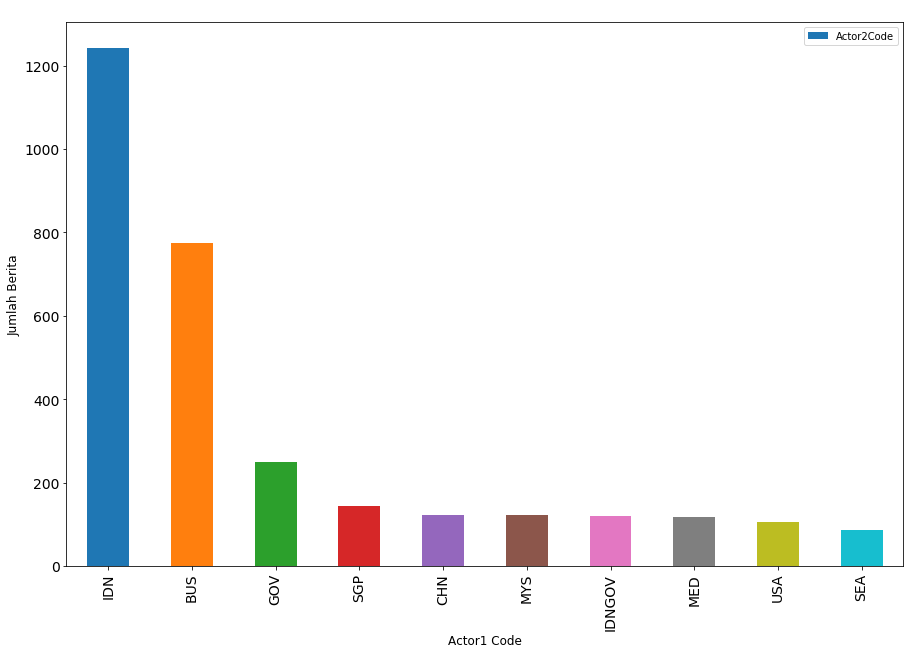

In [16]:
plt.figure(figsize=(15,10))
ax = data_code2.value_counts().head(10)
ax = ax.plot(kind='bar', title =" ", legend=True, fontsize=14)
ax.set_xlabel("Actor1 Code", fontsize=12)
ax.set_ylabel("Jumlah Berita", fontsize=12)

Grafik di atas menunjukkan bahwa Actor2 atau pihak yang memberikan dampak dalam event/berita paling banyak adalah Indonesia (IDN) dengan jumlah 1242 event/berita. Actor2 lainnya yang banyak muncul antara lain adalah BUS (Business), GOV (Pemerintah), SGP (Singapura), dan CHN (China). Terdapat perbedaan dengan Actor1 sebelumnya karena peringkat 5 untuk Actor2 adalah CHN atau China.

### ACTOR COUNTRY CODE

Actor country code merupakan kode yang lebih spesifik dibandingkan dengan Actor Code. Country code menunjukkan aktor dari setiap berita yang sudah diolah berdasarkan negaranya.

In [17]:
data_act1 = data_5yearsdup['Actor1CountryCode']
data_act1.value_counts()
data_act1.describe()

count     3696
unique      73
top        IDN
freq      2112
Name: Actor1CountryCode, dtype: object

Text(0,0.5,'Jumlah Berita')

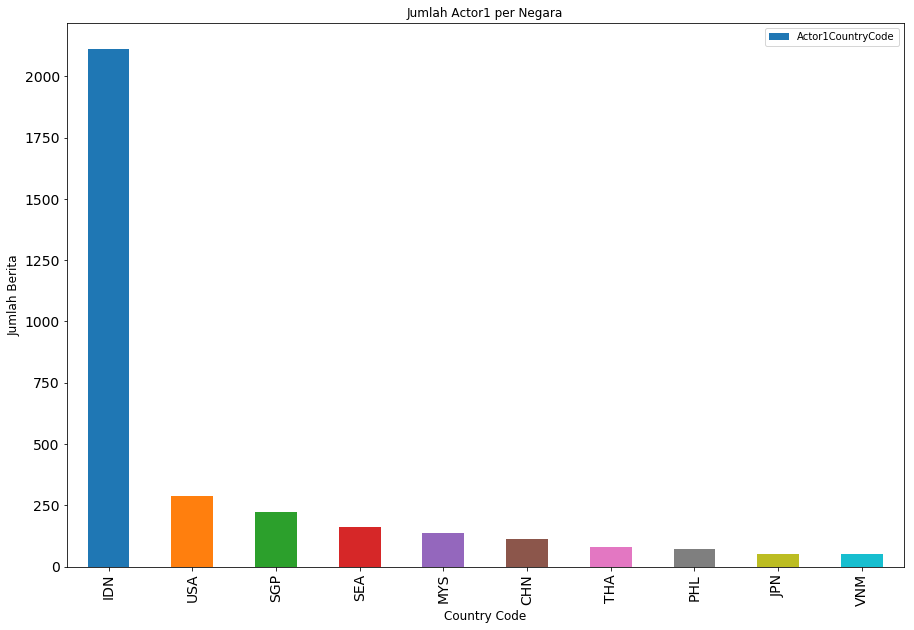

In [18]:
plt.figure(figsize=(15,10))
ax = data_act1.value_counts().head(10)
ax = ax.plot(kind='bar', title ="Jumlah Actor1 per Negara", legend=True, fontsize=14)
ax.set_xlabel("Country Code", fontsize=12)
ax.set_ylabel("Jumlah Berita", fontsize=12)

Berdasarkan grafik di atas, dapat diketahui bahwa Indonesia merupakan negara yang menjadi actor-1 terbanyak di pemberitaan startup. Hal tersebut mengindikasikan bahwa Indonesia banyak menjadi  pihak yang memberikan dampak di berita startup Indonesia. Adapun yang menjadi pihak yang memberikan dampak terbanyak pada event/berita startup Indonesia selanjutnya adalah USA (Amerika), SGP (Singapura), SEA (Asia Tenggara), dan MYS (Malaysia).

In [19]:
data_act2 = data_5yearsdup['Actor2CountryCode']
data_act2.value_counts()
data_act2.describe()

count     2963
unique      67
top        IDN
freq      1516
Name: Actor2CountryCode, dtype: object

Text(0,0.5,'Jumlah Berita')

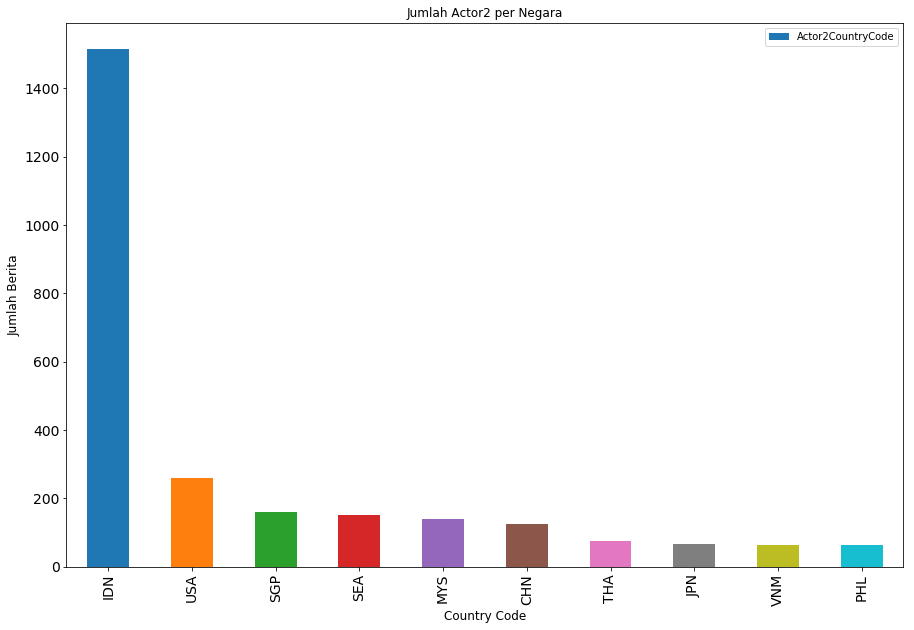

In [20]:
plt.figure(figsize=(15,10))
ax = data_act2.value_counts().head(10)
ax = ax.plot(kind='bar', title ="Jumlah Actor2 per Negara", legend=True, fontsize=14)
ax.set_xlabel("Country Code", fontsize=12)
ax.set_ylabel("Jumlah Berita", fontsize=12)

Dari deskripsi di atas, didapatkan informasi bahwa pada berita startup, terdapat 67 Country Code yang menjadi objek berita startup di Indonesia. Di antara objek berita di atas, yang terbanyak menjadi objek berita adalah Indonesia. Berdasarkan grafik, dapat diketahui bahwa Indonesia merupakan negara yang menjadi actor-2 terbanyak di pemberitaan startup. Hal tersebut mengindikasikan bahwa Indonesia banyak menjadi objek pemberitaan atau pihak yang terkena dampak di berita startup dunia. Sama dengan actor 1, yang menjadi objek pemberitaan terbanyak setelah Indonesia adalah USA (Amerika), SGP (Singapura), SEA (Asia Tenggara), dan MYS (Malaysia). 

### ACTOR NAME

Actor name menunjukkan nama sebenarnya dari Aktor 1 secara lengkap. Nama tersebut dapat berupa pemimpin atau organisasi politik, kategori geografis itu akan menjadi negara atau nama kota besar serta berupa etnis, agama, dan jenis lainnya. 

In [21]:
data_name1 = data_5yearsdup['Actor1Name']
data_name1.value_counts()
data_name1.describe()

count          5651
unique          340
top       INDONESIA
freq           1494
Name: Actor1Name, dtype: object

Text(0,0.5,'Jumlah Berita')

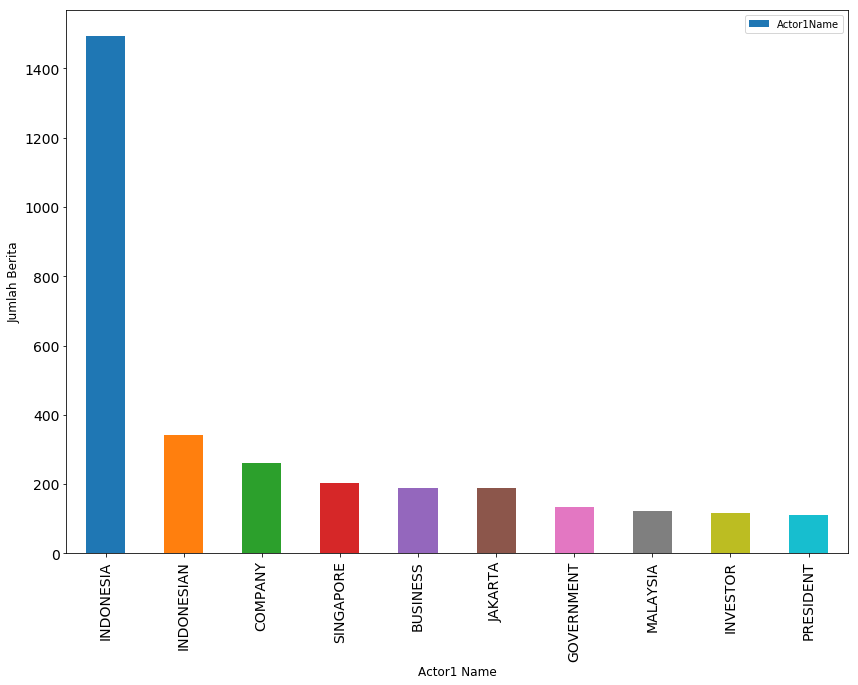

In [22]:
plt.figure(figsize=(14,10))
ax = data_name1.value_counts().head(10)
ax = ax.plot(kind='bar', title ="", legend=True, fontsize=14)
ax.set_xlabel("Actor1 Name", fontsize=12)
ax.set_ylabel("Jumlah Berita", fontsize=12)

Dari grafik di atas dapat dilihat bahwa actor 1 yang menjadi actor 1 atau pemberi dampak pada event/berita terbanyak adalah Indonesia yang ditunjukkan dengan kata 'Indonesia' dan 'Indonesian'. Selain itu, Company, Singapore, dan Business menjadi actor1 dengan frekuensi terbanyak lainnya.

In [23]:
data_name2 = data_5yearsdup['Actor2Name']
data_name2.value_counts()
data_name2.describe()

count          4424
unique          323
top       INDONESIA
freq           1089
Name: Actor2Name, dtype: object

Text(0,0.5,'Jumlah Berita')

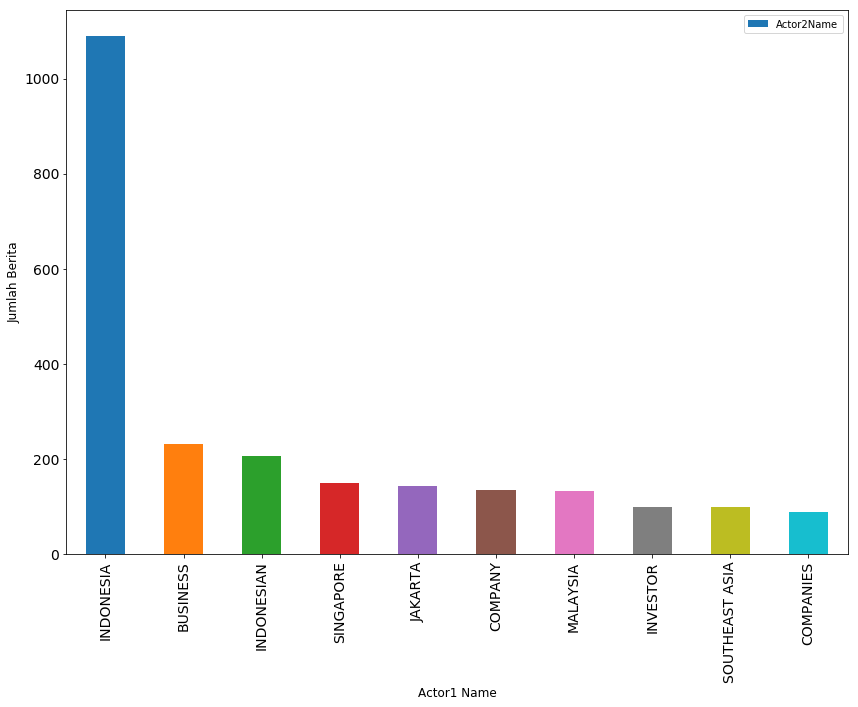

In [24]:
plt.figure(figsize=(14,10))
ax = data_name2.value_counts().head(10)
ax = ax.plot(kind='bar', title ="", legend=True, fontsize=14)
ax.set_xlabel("Actor1 Name", fontsize=12)
ax.set_ylabel("Jumlah Berita", fontsize=12)

Sama seperti actor 1 name, dapat dilihat bahwa yang menjadi actor 2 atau objek berita terbanyak adalah Indonesia yang ditunjukkan dengan kata 'Indonesia' dan 'Indonesian'. Namun, actor lainnya yang menjadi objek berita adalah Business, Singapore, dan Jakarta dengan frekuensi terbanyak lainnya.

### IDN sebagai Actor 1

Berikut ini merupakan Actor2 yang menjadi pihak yang terdampak dari event/berita yang dilakukan oleh Indonesia (Actor1).

In [26]:
actcode=data_5yearsdup[['Actor1CountryCode', 'Actor2CountryCode']]
act1ind=actcode[actcode['Actor1CountryCode']=='IDN']
act1ind.describe()

act1ind_act2=act1ind['Actor2CountryCode']
act1ind_act2.value_counts()

IDN    244
USA    111
SGP     71
SEA     71
MYS     53
CHN     52
PHL     33
THA     31
JPN     30
AUS     27
VNM     22
FRA     16
DEU     12
GBR      9
CAN      7
NLD      7
EUR      7
NZL      6
NOR      5
KOR      5
BRA      5
TUR      4
CHE      4
ARE      3
TWN      2
PSE      2
IND      2
KAZ      2
ITA      2
LIE      2
MEX      2
ISR      2
ARG      2
MMR      2
QAT      2
IRN      1
PER      1
COL      1
SAU      1
LKA      1
BFA      1
PAK      1
MCO      1
AFR      1
BGD      1
GUY      1
Name: Actor2CountryCode, dtype: int64

Text(0,0.5,'Jumlah Berita')

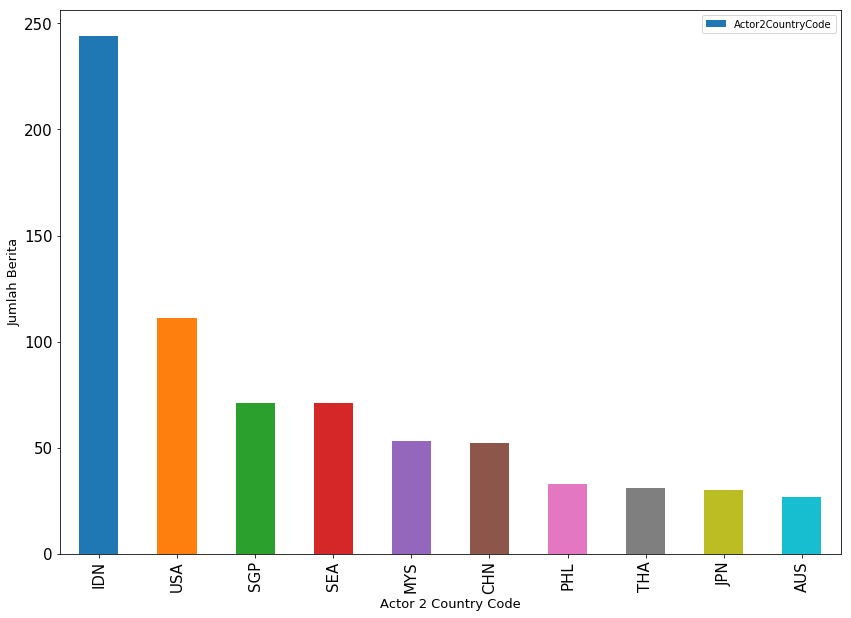

In [27]:
plt.figure(figsize=(14,10))
ax = act1ind_act2.value_counts().head(10)
ax = ax.plot(kind='bar', title ="", legend=True, fontsize=15)
ax.set_xlabel("Actor 2 Country Code", fontsize=13)
ax.set_ylabel("Jumlah Berita", fontsize=13)

Grafik di atas menunjukkan Actor 2 atau pihak yang terkena dampak dari berita yang dilakukan oleh IDN sebagai Actor 1. Dari grafik didapatkan bahwa Indonesia sebagai Actor 1 memberikan dampak terbanyak pada Indonesia sendiri. Selanjutnya, Indonesia paling banyak memberikan dampak pada Amerika Serikat (USA), Asia Tenggara (SEA), Singapura (SGP) dan Malaysia (MYS). 

### IDN sebagai Actor 2

Berikut ini merupakan Actor1 yang menjadi pihak yang memberikan dampak dari event/berita yang dilakukan oleh Indonesia (Actor2).

In [28]:
act2ind=actcode[actcode['Actor2CountryCode']=='IDN']
act2ind.describe()

act2ind_act1=act2ind['Actor1CountryCode']
act2ind_act1.value_counts()

IDN    244
USA     98
SGP     78
MYS     49
SEA     48
CHN     42
AUS     26
THA     24
PHL     23
NOR     15
JPN     15
FRA     14
KOR     12
NZL     10
VNM      9
DEU      6
GBR      6
EUR      5
BRA      4
RUS      4
CHE      4
CAN      4
JOR      3
NLD      3
ARE      3
BGD      3
AFR      3
BRN      3
LIE      2
IRN      2
TWN      2
SAU      2
MEX      2
ISR      2
TUR      2
SOM      2
MCO      2
IND      1
UGA      1
ITA      1
LKA      1
EGY      1
QAT      1
COL      1
KHM      1
GUY      1
Name: Actor1CountryCode, dtype: int64

Text(0,0.5,'Jumlah Berita')

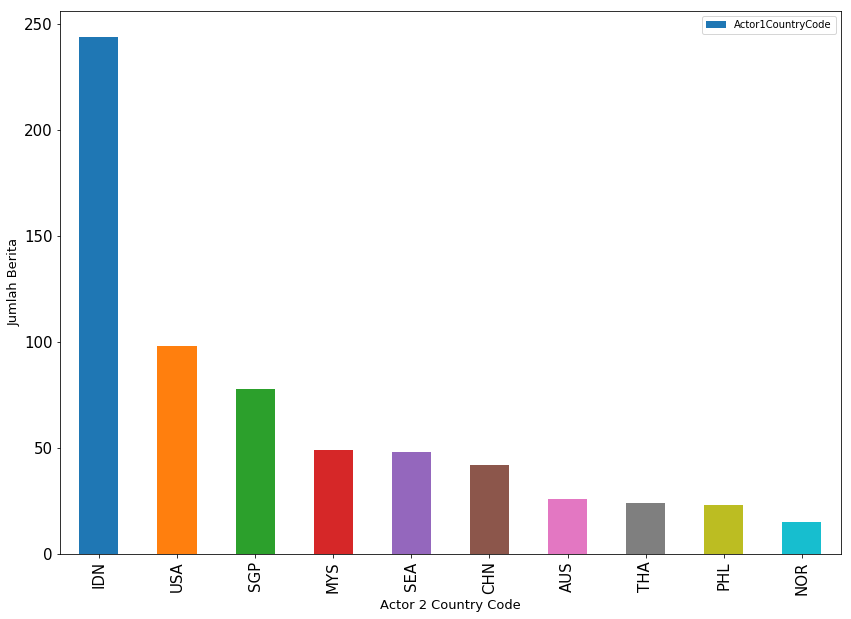

In [29]:
plt.figure(figsize=(14,10))
ax = act2ind_act1.value_counts().head(10)
ax = ax.plot(kind='bar', title ="", legend=True, fontsize=15)
ax.set_xlabel("Actor 2 Country Code", fontsize=13)
ax.set_ylabel("Jumlah Berita", fontsize=13)

Grafik di atas menunjukkan Actor 1 atau pihak yang memberikan dampak atas berita kepada IDN sebagai Actor 2. Dari grafik didapatkan bahwa Indonesia sebagai Actor 2 merupakan pihak terdampak terbanyak atas pemberitaan Indonesia sendiri. Selanjutnya, Indonesia paling banyak diberikan dampak oleh Amerika Serikat (USA), Singapura (SGP), Malaysia (MYS) dan Asia Tenggara (SEA). 

## Goldstein Scale

Goldsteinscale merupakan skala dari dampak teoritis suatu event/kejadian/berita terhadap stabilitas suatu negara. Skala dinilai dari skor tertinggi (positif) yaitu 10 dan skor terendah(negatif) yaitu -10

In [4]:
# See stats of Goldsteinscale variable
Goldsteinscale_desc = data_5years['GoldsteinScale'].describe()
low_q = Goldsteinscale_desc[4]
high_q = Goldsteinscale_desc[6]
iqr = high_q - low_q

print(Goldsteinscale_desc)

count    2133.000000
mean        2.453586
std         3.893877
min       -10.000000
25%         0.000000
50%         3.000000
75%         5.200000
max        10.000000
Name: GoldsteinScale, dtype: float64


dari data diatas rata-rata skor goldstein scale nya yaitu 2.45 yang berarti event/berita startup di Indonesia cenderung berdampak positif terhadap stabilitas negara. Dengan standard deviasi 3.89. sedangkan nilai min -10 dan nilai maksimum 10.

Jumlah outlier negatif = 59
Jumlah outlier positif = 0


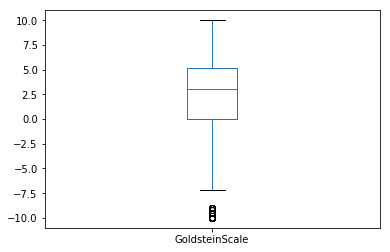

In [5]:
# See the data by box plot
data_5years['GoldsteinScale'].plot.box()

# Check outlier data
lower_threshold = low_q - iqr * 1.5
higher_threshold = high_q + 1.5 * iqr

data_outlier_negative = data_5years.loc[data_5years['GoldsteinScale']
                                        < lower_threshold]
data_outlier_positive = data_5years.loc[data_5years['GoldsteinScale']
                                        > higher_threshold]

print("Jumlah outlier negatif = " + str(data_outlier_negative.shape[0]))
print("Jumlah outlier positif = " + str(data_outlier_positive.shape[0]))

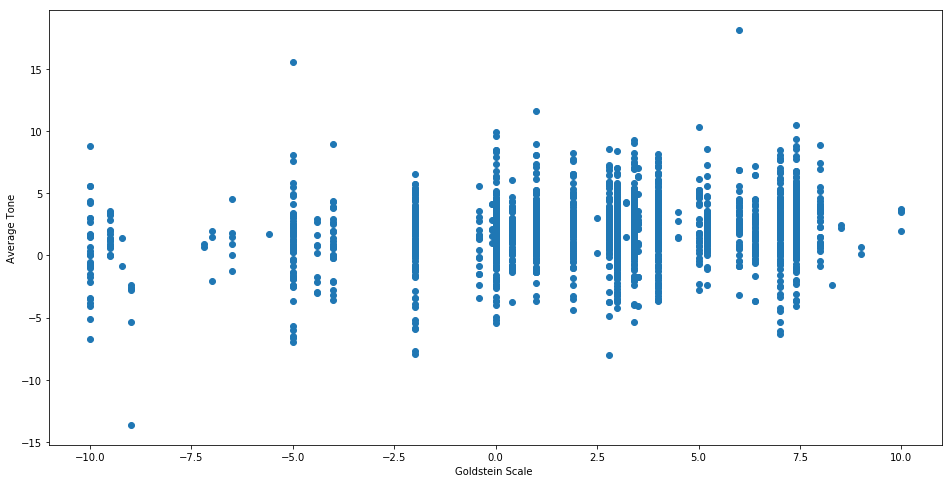

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data_5years ['GoldsteinScale'], data_5years ['AvgTone'])
ax.set_xlabel('Goldstein Scale ')
ax.set_ylabel('Average Tone')
plt.show()

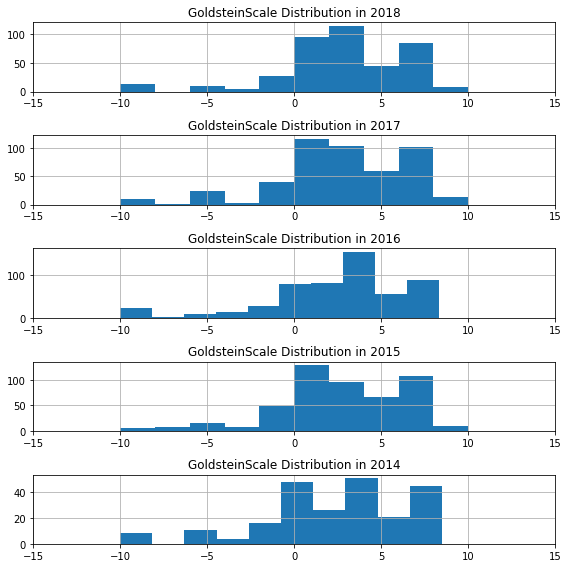

In [7]:
# Explore by tone
import matplotlib.pyplot as plt
def plot_histogram(df, n_rows, n_cols):
    fig = plt.figure()
    i = 0
    for tahun in df.Year.unique():
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df['GoldsteinScale'].loc[df['Year'] == tahun].hist(
            bins=10,ax=ax,figsize=(8,8))
        ax.set_title("GoldsteinScale Distribution in " + str(tahun))
        ax.set_xlim(-15, 15)
        i = i + 1
    fig.tight_layout()
    plt.show()
    
plot_histogram(data_5years, 5, 1)

Dari histogram diatas menunjukkan bahwa persebaran data cenderung condong ke kanan yang bermakna event/berita memiliki GoldsteinScale yang cenderung positif yaitu event/berita tentang startup berdampak positif terhadap stabilitas suatu negara

In [24]:
# Read CAMEO Event Codes
data_event_codes = pd.read_csv("CAMEO.eventcodes.txt", sep="\t")
event = data_5years.groupby('EventCode')['GoldsteinScale'].describe().reset_index()

print("Displaying top 5 Event Code")
event.sort_values('count', ascending=False).head()

# Unknown error - Merge gives duplicate rows and wrong results, hence 
# we don't merge them right now
# data_event_codes = data_event_codes.rename(columns={'CAMEOEVENTCODE':'EventCode'})
# event_code = pd.merge(event, data_event_codes, on = ['EventCode'], how = 'inner')
# event_code

Displaying top 5 Event Code


,EventCode,count,mean,std,min,25%,50%,75%,max
37,71,209.0,7.4,1.958684e-14,7.4,7.4,7.4,7.4,7.4
0,10,203.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
8,20,194.0,3.0,0.000000e+00,3.0,3.0,3.0,3.0,3.0
28,51,167.0,3.4,1.024477e-14,3.4,3.4,3.4,3.4,3.4
20,40,135.0,1.0,0.000000e+00,1.0,1.0,1.0,1.0,1.0


## Numbers of Mention, Sources, dan Article

Bagian ini akan menganalisis kolom Number of Mention, Number of Sources, dan Number of Article

In [3]:
#Import data 3 kolom yang diperlukan
olah_data=data_5years[['NumMentions', 'NumSources', 'NumArticles']]

In [4]:
#Cek NumMentions yang sering muncul untuk 15 nilai
olah_data['NumMentions'].value_counts().sort_values(ascending=False).head(15)

10    519
2     350
5     216
4     212
6     153
1     151
3     126
8     123
20     67
7      33
12     27
16     25
30     19
15     14
14      9
Name: NumMentions, dtype: int64

In [5]:
#Cek NumMentions yang sering muncul untuk 15 nilai
olah_data['NumSources'].value_counts().sort_values(ascending=False).head(15)

1     1883
2      158
3       40
4       18
5       10
8        5
6        4
7        3
9        2
10       2
14       1
35       1
15       1
13       1
39       1
Name: NumSources, dtype: int64

In [6]:
#Cek NumMentions yang sering muncul untuk 15 nilai
olah_data['NumArticles'].value_counts().sort_values(ascending=False).head(15)

10    524
2     350
5     217
4     212
6     153
1     151
3     127
8     125
20     66
7      35
12     26
16     21
30     19
15     13
9       8
Name: NumArticles, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002221D5631D0>,
      dtype=object)

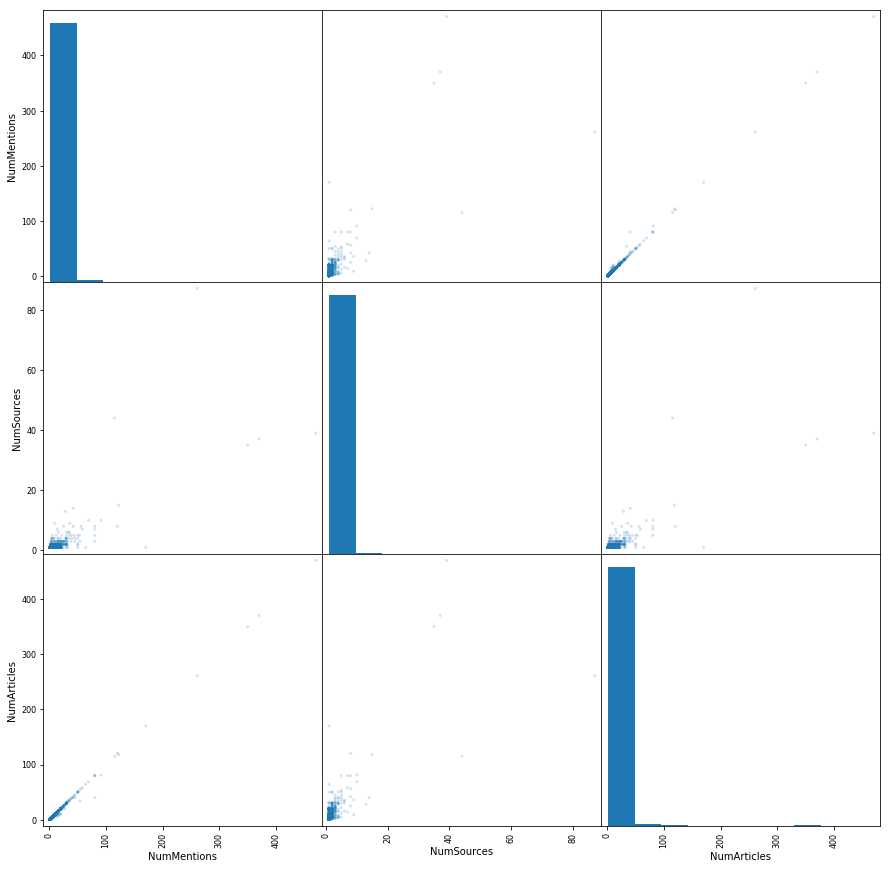

In [8]:
#Mengecek hubungan korelasi masing masing data
pd.plotting.scatter_matrix(olah_data, alpha=0.2, figsize=(15,15))

In [9]:
olah_data.corr()

,NumMentions,NumSources,NumArticles
NumMentions,1.000000,0.768046,0.998069
NumSources,0.768046,1.000000,0.770544
NumArticles,0.998069,0.770544,1.000000


In [10]:
olah_data.describe()

,NumMentions,NumSources,NumArticles
count,2133.000000,2133.000000,2133.000000
mean,8.436006,1.335209,8.352086
std,18.332024,2.634143,18.210884
min,1.000000,1.000000,1.000000
25%,3.000000,1.000000,3.000000
50%,6.000000,1.000000,6.000000
75%,10.000000,1.000000,10.000000
max,470.000000,87.000000,470.000000


In [11]:
#mengecek banyak data NumMentions antara 100 hingga 470 
run("""
SELECT 
    * 
FROM 
    startup_indonesia 
WHERE 
    NumMentions BETWEEN '100' AND '470'
""").drop_duplicates('SOURCEURL').shape

(8, 59)

In [12]:
run("""
SELECT 
    * 
FROM 
    startup_indonesia 
WHERE 
    NumSources BETWEEN '10' AND '87'
""").drop_duplicates('SOURCEURL').shape

(10, 59)

Apabila di cermati, NumMentions dan NumArticles memiliki nilai mean dan standar deviasi yang hampir sama besar. Nilai korelasi keduanyapun cukup mendekati 1 (yakni 0.998). Dengan demikian, kami mengasumsikan bahwa keduanya adalah sama, sehingga kita cukup memilih salah satu untuk di analisis.

Untuk data dari NumMentions dan NumArticles tidak ada yang kosong. Data memiliki rentang dari 0 hingga suatu nilai dan bernilai positif. Apabila dicermati ada pencilan atas, yang nilainya sangat jauh dari rata rata. Untuk pengolahan selanjutnya data ini dapat dihilangkan, tetapi Untuk tahap ini masih diikutkan.

### Plot ke diagram batang

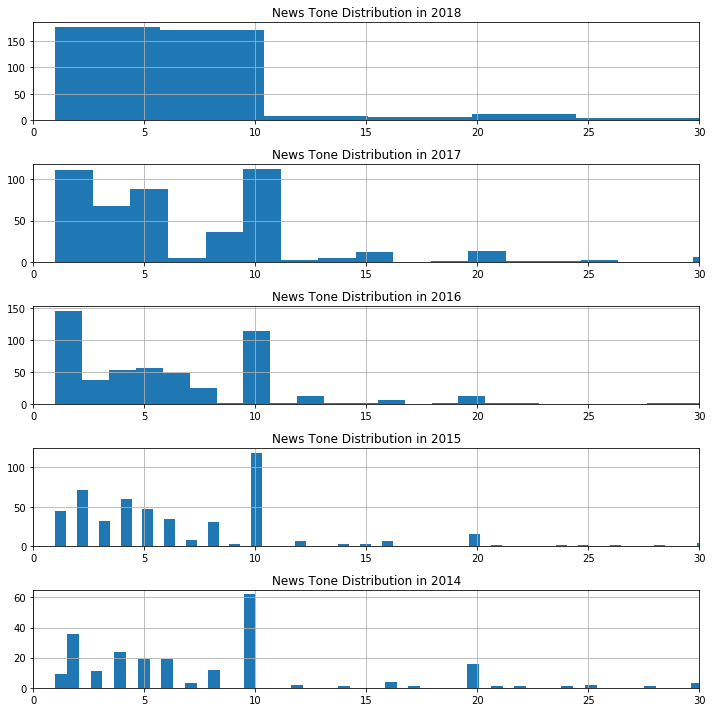

In [13]:
# Explore by tone
import matplotlib.pyplot as plt
def plot_histogram(df, n_rows, n_cols):
    fig = plt.figure()
    i = 0
    for tahun in df.Year.unique():
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df['NumMentions'].loc[df['Year'] == tahun].hist(
            bins=100,ax=ax,figsize=(10,10))
        ax.set_title("News Tone Distribution in " + str(tahun))
        ax.set_xlim(0, 30)
        i = i + 1
    fig.tight_layout()
    plt.show()
    
plot_histogram(data_5years, 5, 1)

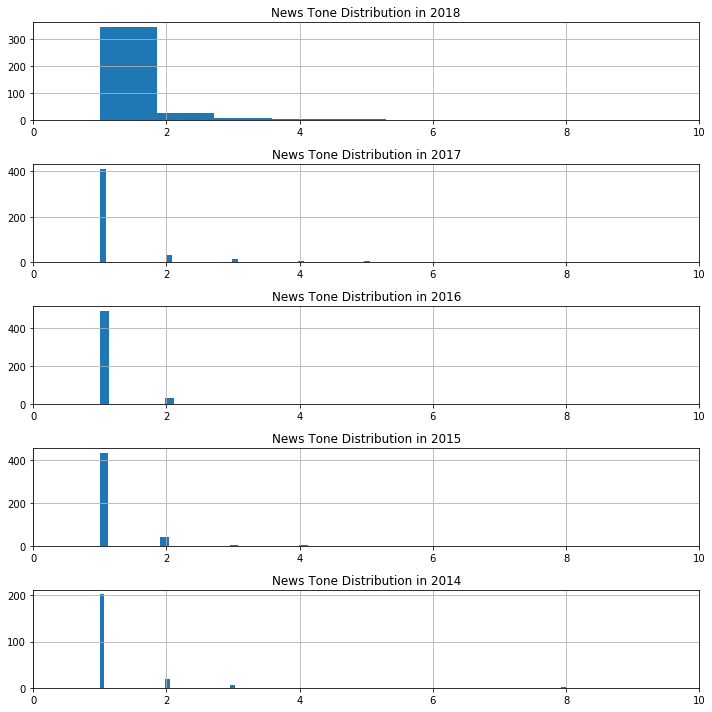

In [14]:
# Explore by tone
import matplotlib.pyplot as plt
def plot_histogram(df, n_rows, n_cols):
    fig = plt.figure()
    i = 0
    for tahun in df.Year.unique():
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df['NumSources'].loc[df['Year'] == tahun].hist(
            bins=100,ax=ax,figsize=(10,10))
        ax.set_title("News Tone Distribution in " + str(tahun))
        ax.set_xlim(0, 10)
        i = i + 1
    fig.tight_layout()
    plt.show()
    
plot_histogram(data_5years, 5, 1)

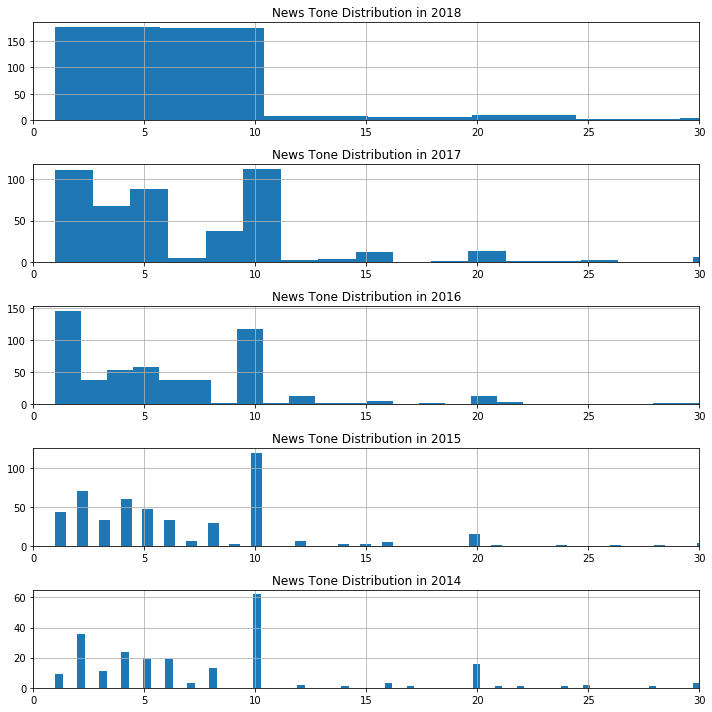

In [15]:
# Explore by tone
import matplotlib.pyplot as plt
def plot_histogram(df, n_rows, n_cols):
    fig = plt.figure()
    i = 0
    for tahun in df.Year.unique():
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df['NumArticles'].loc[df['Year'] == tahun].hist(
            bins=100,ax=ax,figsize=(10,10))
        ax.set_title("News Tone Distribution in " + str(tahun))
        ax.set_xlim(0, 30)
        i = i + 1
    fig.tight_layout()
    plt.show()
    
plot_histogram(data_5years, 5, 1)

Apabila diperhatikan data, lebih banyak berada di sisi kiri dengan kata lain distribusinya tidak merata dan distribusi kemungkinan eksponensial. Dari grafik, pada tahun 2014 hingga tahun 2017 dapat terlihat bahwa data semakin bertambah jumlahnya yang dapat dilihat dari gambar grafik yang semakin 'rapat' dari tahun ke tahun.

### Normalisasi data

Berdasarkan informasi dari GDELT, ketiga data ini perlu di normalkan. Kami menormalkannya dengan cara membagi nilai dengan rataannya selama 5 tahun.

In [16]:
olah_data_=run("""SELECT
    SOURCEURL, Year,
    NumMentions/(SELECT AVG(NumMentions) FROM startup_indonesia) AS Norm_NumMentions, 
    NumSources/(SELECT AVG(NumSources) FROM startup_indonesia) AS Norm_NumSources,
    NumArticles/(SELECT AVG(NumArticles) FROM startup_indonesia) AS Norm_NumArticles
    FROM startup_indonesia""").drop_duplicates('SOURCEURL')

In [17]:
olah_data_2=olah_data_[['Year','Norm_NumMentions','Norm_NumSources','Norm_NumArticles']]
olah_data_2.head()

,Year,Norm_NumMentions,Norm_NumSources,Norm_NumArticles
0,2018,0.7179,0.7515,0.7249
1,2018,1.1966,0.7515,1.2082
2,2018,1.1966,0.7515,1.2082
3,2018,1.1966,0.7515,1.2082
4,2018,0.5983,0.7515,0.6041


In [18]:
olah_data_2.corr()

,Year,Norm_NumMentions,Norm_NumSources,Norm_NumArticles
Year,1.000000,0.085960,0.075036,0.085075
Norm_NumMentions,0.085960,1.000000,0.767218,0.998076
Norm_NumSources,0.075036,0.767218,1.000000,0.769709
Norm_NumArticles,0.085075,0.998076,0.769709,1.000000


In [19]:
olah_data_2.describe()

,Year,Norm_NumMentions,Norm_NumSources,Norm_NumArticles
count,2217.000000,2217.000000,2217.000000,2217.000000
mean,2016.033829,1.000009,0.999982,0.999979
std,1.385599,2.155334,1.944719,2.161990
min,2012.000000,0.119700,0.751500,0.120800
25%,2015.000000,0.359000,0.751500,0.362500
50%,2016.000000,0.717900,0.751500,0.724900
75%,2017.000000,1.196600,0.751500,1.208200
max,2018.000000,56.238700,65.382700,56.787300


Dapat dilihat bahwa normalisasi telah mengubah data yang awalnya berbentuk integer menjadi float. Dengan kata lain, perubahan ini merubah rentang data menjadi lebih sempit. Sebagai contoh, NumMentions yang pada awal nilai maksimalnya adalah 870, saat ini menjadi 56. Namun, jika dilihat hasilnya, proses normalisasi tidak mengubah nilai korelasi antar variabel.

### Apakah ada Korelasi antara GoldsteinScale dengan NumMentions dan NumSources?

In [20]:
olah_data_3=data_5years[['NumMentions', 'NumSources', 'GoldsteinScale']]

In [21]:
olah_data_3.corr()

,NumMentions,NumSources,GoldsteinScale
NumMentions,1.000000,0.768046,0.003200
NumSources,0.768046,1.000000,0.003895
GoldsteinScale,0.003200,0.003895,1.000000


### Apakah ada Korelasi antara AvgTone dengan NumMentions dan NumSources?

In [22]:
olah_data_4=data_5years[['NumMentions', 'NumSources', 'AvgTone']]

In [23]:
olah_data_4.corr()

,NumMentions,NumSources,AvgTone
NumMentions,1.000000,0.768046,-0.03179
NumSources,0.768046,1.000000,-0.03202
AvgTone,-0.031790,-0.032020,1.00000


Berdasarkan data di atas, dapat diketahui bahwa data NumMentions dan Numsources memiliki nilai korelasi yang rendah dengan Goldstein dan AvgTone. Dengan kata lain GoldsteinScale dan AvgTone tidak memiliki korelasi yang nyata dengan NumMentions maupun NumSources.

## Average Tone

In [27]:
# See stats of AvgTone variable
avgtone_desc = data_5years['AvgTone'].describe()
low_q = avgtone_desc[4]
high_q = avgtone_desc[6]
iqr = high_q - low_q

print(avgtone_desc)

count    2133.000000
mean        1.998609
std         2.506583
min       -13.636364
25%         0.699301
50%         2.027027
75%         3.375338
max        18.139535
Name: AvgTone, dtype: float64


Berdasarkan data tersebut, terlihat bahwa berita startup memiliki nada yang cenderung netral dengan skala dari -13,63 hingga 18,13 dan median 2,02. Ada bebarapa data outlier, dengan nada yang terlalu negatif maupun terlalu positif.

Seberapa banyak data nada berita yang outlier?

Jumlah outlier negatif = 66
Jumlah outlier positif = 46


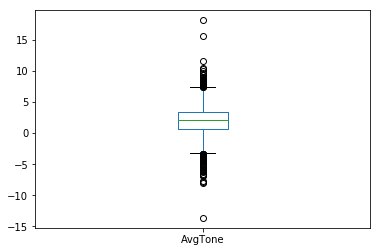

In [28]:
# See the data by box plot
data_5years['AvgTone'].plot.box()

# Check outlier data
lower_threshold = low_q - iqr * 1.5
higher_threshold = high_q + 1.5 * iqr

data_outlier_negative = data_5years.loc[data_5years['AvgTone'] 
                                        < lower_threshold]
data_outlier_positive = data_5years.loc[data_5years['AvgTone'] 
                                        > higher_threshold]

print("Jumlah outlier negatif = " + str(data_outlier_negative.shape[0]))
print("Jumlah outlier positif = " + str(data_outlier_positive.shape[0]))

Ternyata data outlier yang ada lumayan banyak, berjumlah puluhan.

Lalu bagaimana persebaran nada berita berdasarkan tahunnya?

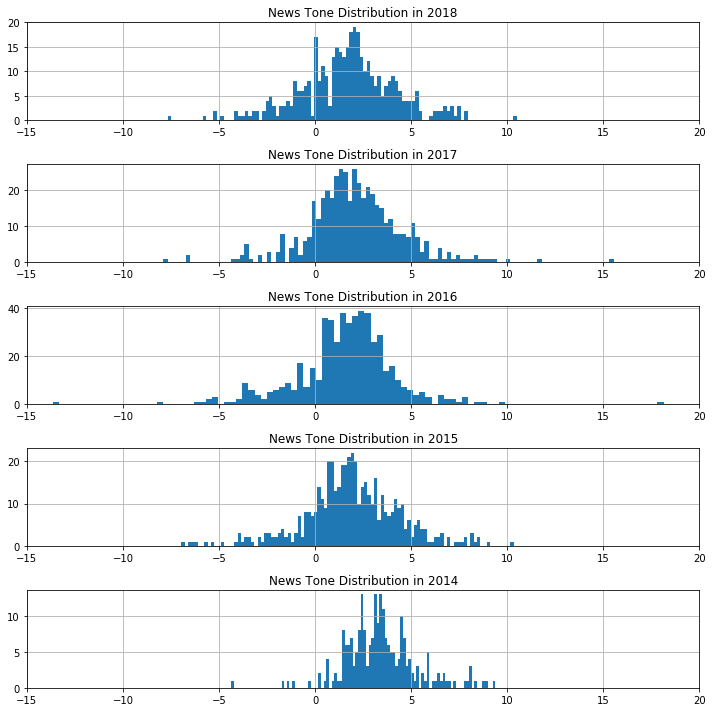

In [29]:
# Explore by tone
import matplotlib.pyplot as plt
def plot_histogram(df, n_rows, n_cols):
    fig = plt.figure()
    i = 0
    for tahun in df.Year.unique():
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df['AvgTone'].loc[df['Year'] == tahun].hist(
            bins=100,ax=ax,figsize=(10,10))
        ax.set_title("News Tone Distribution in " + str(tahun))
        ax.set_xlim(-15, 20)
        i = i + 1
    fig.tight_layout()
    plt.show()
    
plot_histogram(data_5years, 5, 1)

Persebaran data tiap tahunnya memiliki distribusi normal. Persebaran tahun 2014 condong lebih ke kanan (ke arah positif) dibandingkan tahun lainnya, menandakan adanya sedikit antusiasme startup di tanah air pada tahun tersebut.

Dalam GDELT, ada juga variabel Goldstein Scale. Goldstein Scale menggambarkan pengaruh kejadian di berita terhadap kestabilan negara. Apakah nada berita berkorelasi terhadap Goldstein Scale?

Nilai korelasi = 0.17405016782227048


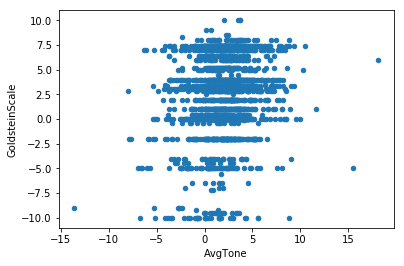

In [30]:
# Compare both AvgTone with GoldsteinScale
data_5years.plot.scatter(x='AvgTone', y='GoldsteinScale')
corr_AvgTone_GoldsteinScale = data_5years['AvgTone'].corr(
    data_5years['GoldsteinScale'])
print("Nilai korelasi = " + str(corr_AvgTone_GoldsteinScale))

Kita juga ingin mengecek bagaimana hubungan antara EventCode dengan nada berita. Untuk analisis ini, kita menggunakan data [CAMEO Event Codes](https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt). Data ini menggambarkan event berita.

In [31]:
# Read CAMEO Event Codes
data_event_codes = pd.read_csv("CAMEO.eventcodes.txt", sep="\t")
event = data_5years.groupby('EventCode')['AvgTone'].describe().reset_index()

print("Displaying top 5 Event Code")
event.sort_values('count', ascending=False).head()

Displaying top 5 Event Code


,EventCode,count,mean,std,min,25%,50%,75%,max
37,71,209.0,2.433928,2.218664,-4.081633,1.207815,2.311248,3.400000,10.488136
0,10,203.0,1.849129,2.156948,-5.431629,0.926314,1.938421,3.034698,8.495093
8,20,194.0,1.784534,2.265749,-4.263493,0.480124,1.768489,3.170771,8.387097
28,51,167.0,2.413918,2.230212,-5.352798,1.233203,2.256012,3.680357,9.296482
20,40,135.0,2.269778,2.330204,-3.680982,0.874198,2.093802,3.537683,11.598746


Berdasarkan data tersebut, kita dapatkan bahwa 5 event teratas yang paling sering terjadi dalam bidang startup adalah:

1. 71 -- Provide economic aid
2. 10 -- DEMAND
3. 20 -- USE UNCONVENTIONAL MASS VIOLENCE
4. 51 -- Appeal for easing of administrative sanctions
5. 40 -- Consult, not specified

Poin nomor 3 terkesan aneh, karena dalam bisnis tidak ada kekerasan. Hal ini perlu analisis lebih lanjut.

## Research Question
1. Event seputar apa saja yang sedang ngetren di Indonesia?
2. Apa saja hal menarik yang di bahas di dunia internasional terkait start up di Indonesia?
3. Bagaimana persepsi dunia internasional tentang startup Indonesia? 
4. Investor di startup indo & pengaruhnya terhadap perkembangan startup di indo?
5. Mengapa startup di indo "menarik" dimata investor luar negeri?
6. Sentimen pendanaan di Indonesia dan kedepannya, industri apa yang diincar?
7. Seberapa besar pengaruh negara luar terhadap perkembangan startup Indonesia?

# MILESTONE 3 - Machine Learning

## Model Pembelajaran Mesin Yang Diterapkan

  Data yang telah tersedia akan dianalisis lebih lanjut untuk mendapatkan jawaban dari research question dengan menerapkan model pembelajaran mesin yang telah dipelajari, yaitu:
  
### Classification 

Kami akan melakukan klasifikasi event berdasarkan eventcode dan pelabelan topik event/berita. Metode klasifikasi yang dipakai adalah Naive Bayes yang merupakan lanjutan dari SVC.

### Clustering

Kami akan melakukan klastering data dari data awal yang belum diketahui labelnya untuk mendapatkan insight baru. Jenis klastering yang diterapkan adalah K Means.

### Regresi 

Kami akan memprediksi besar average tone menggunakan teks berita. Metode regresi yang digunakan yaitu Ridge Regression.

## Dasar Pemilihan Metode

### Classification - Naive Bayes

Pemilihan metode didasari atas data latih berupa artikel berita dalam bentuk teks. Teks memiliki beragam kata yang akan dikonversi menjadi vektor, menyebabkan dimensi data begitu besar (sparse data). Selain itu, jumlah data artikel startup hanya berkisar dua ribu data. Metode Linear SVC bisa diterapkan pada data yang sedikit, namun tidak bisa untuk sparse data. Berdasarkan kondisi tersebut, maka dipilihlah metode klasifikasi Naive Bayes.
   
### Clustering - K Means

Pemilihan metode K Means didasarkan pada tujuan kami untuk menemukan pola kelompok dalam data. Dalam kasus data startup ini, kami mengasumsikan ada beberapa kemungkinan kelompok data berdasarkan kategori berita. Contoh kategori berita seperti:

    - Pendanaan startup oleh investor    
    - Startup baru rintis    
    - Startup berhasil exit    
    - Konflik startup dengan regulasi / lingkungan    
    - dll..

Atas dasar rencana tersebut, metode clustering cocok untuk kasus ini. Adapun K Means dipilih karena data berita yang sedikit serta jumlah kategori yang dicari masih bisa kami temukan kisaran jumlahnya.

### Regression - Ridge Regression

Pemilihan ridge regression didasari oleh data teks yang bersifat sparse. Karena data bersifat sparse, ada kemungkinan terjadinya multicollinearity antar satu variabel prediktor satu dengan yang lain. Metode linear regression dapat menghasilkan hasil prediksi yang bersifat high-variance jika menggunakan data ini, sehingga linear regression bukan metode yang cocok. Untuk mengatasi masalah data tersebut, maka digunakan metode ridge regression. Metode ini menambahkan nilai bias pada persamaan matematisnya, menyebabkan perhitungan bisa menyesuaikan lebih adaptif untuk mencegah varians tersebut.

# MILESTONE 4 - Penerapan Machine Learning
Pada bagian ini, kami akan menggunakan beberapa algoritma kecerdasan buatan yang dibahas di Milestone 3.

In [1]:
import keras
import pandas as pd
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Dalam penerapan machine learning ini, kami telah mereview data secara manual. Hasil review tersebut memberikan 1252 baris valid.

In [2]:
df = pd.read_csv("berita startup 2014-2018.csv", sep = ";", encoding="ISO-8859-1")
df.head()

,Unnamed: 0,GLOBALEVENTID,index,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,...,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL,ARTICLEURL,ARTICLETITLE
0,0.0,795321987,38.0,20181017,201810,2018,2018.7863,BUS,COMPANY,NaN,...,Indonesia,ID,ID,-5.00000,120.000,ID,20181017.0,https://www.coindesk.com/f2pool-founders-crypt...,"Cobo, a Beijing-based cryptocurrency wallet st...",F2Pool Founderâs Crypto Wallet Startup Raise...
1,1.0,786638486,245.0,20180913,201809,2018,2018.6932,CHN,CHINA,CHN,...,Indonesia,ID,ID,-5.00000,120.000,ID,20180913.0,https://economictimes.indiatimes.com/small-biz...,BENGALURU: When hotel chain OYO decided to exp...,How Ritesh Agarwal's OYO scaled the great wall...
2,2.0,783214317,312.0,20180830,201808,2018,2018.6575,IDNBUS,INDONESIA,IDN,...,"Jakarta, Jakarta Raya, Indonesia",ID,ID04,-6.17444,106.829,-2679652,20180830.0,http://www.en.netralnews.com/news/business/rea...,Ã°Å¸âÅ Listen to this\r\r\n\r\r\n\r\r\n\r\r...,Minister of Communication and Information Aims...
3,4.0,749145806,708.0,20180419,201804,2018,2018.2986,IDN,INDONESIA,IDN,...,Indonesia,ID,ID,-5.00000,120.000,ID,20180419.0,https://economictimes.indiatimes.com/small-biz...,"In the last six months, employees at Razorpay ...",Customer-connect a whole new ball game at star...
4,5.0,741541805,813.0,20180324,201803,2018,2018.2301,IDN,INDONESIA,IDN,...,"Jakarta, Jakarta Raya, Indonesia",ID,ID04,-6.17444,106.829,-2679652,20180324.0,http://www.en.netralnews.com/news/currentnews/...,Ã°Å¸âÅ Listen to this\r\r\n\r\r\n\r\r\n\r\r...,"15 Indonesia-Singapore Startups Join, Collabor..."


In [3]:
df_text = df[["ARTICLEURL", "ARTICLETITLE"]]
df_text.head()

,ARTICLEURL,ARTICLETITLE
0,"Cobo, a Beijing-based cryptocurrency wallet st...",F2Pool Founderâs Crypto Wallet Startup Raise...
1,BENGALURU: When hotel chain OYO decided to exp...,How Ritesh Agarwal's OYO scaled the great wall...
2,Ã°Å¸âÅ Listen to this\r\r\n\r\r\n\r\r\n\r\r...,Minister of Communication and Information Aims...
3,"In the last six months, employees at Razorpay ...",Customer-connect a whole new ball game at star...
4,Ã°Å¸âÅ Listen to this\r\r\n\r\r\n\r\r\n\r\r...,"15 Indonesia-Singapore Startups Join, Collabor..."


In [4]:
text = df_text["ARTICLETITLE"].map(str) + " " + df_text["ARTICLEURL"].map(str)

In [5]:
text.head()

0    F2Pool Founderâs Crypto Wallet Startup Raise...
1    How Ritesh Agarwal's OYO scaled the great wall...
2    Minister of Communication and Information Aims...
3    Customer-connect a whole new ball game at star...
4    15 Indonesia-Singapore Startups Join, Collabor...
dtype: object

In [6]:
text[1]

"How Ritesh Agarwal's OYO scaled the great wall of China BENGALURU: When hotel chain OYO decided to expand to China in December, the go-to market strategy was clear in chief executive Ritesh AgarwalÃ¢â\x82¬â\x84¢s mind. He didnÃ¢â\x82¬â\x84¢t want to think like an Indian company launching operations in another country. Instead, Ã¢â\x82¬Å\x93we wanted to think like a company in China that was trying to emulate OYO.Ã¢â\x82¬Â\x9d This, Agarwal believes, helped OYO take a more local approach and avoid some of the mistakes a foreign company would commit.Ã¢â\x82¬Å\x93Most companiesÃ¢â\x82¬Â¦ usually go to China as if they are launching a foreign company in China,Ã¢â\x82¬Â\x9d Agarwal told ET. Ã¢â\x82¬Å\x93From our perspective, the only (hotel) company that can do a good job (in China) would be one that emulates OYO.Ã¢â\x82¬Â\x9dSo for every decision that the OYO team has to make in China, they ask, Ã¢â\x82¬Å\x93What would the company that was copying OYO do?Ã¢â\x82¬Â\x9d, and plan accordingl

In [7]:
# hai = text[1].encode('utf-8', 'ignore').decode('utf-8')
# hai = [word for word in text[1].split(" ") if word.isalpha()]
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(txt):
    txt_c = re.sub(r'[^A-Za-z0-9]+', ' ', txt)
    txt_c = txt_c.split(" ")
    words = [w for w in txt_c if not w in stop_words]
    txt_c = " ".join(words)
    txt_c = txt_c.lower()
    return txt_c

text_clear = text.apply(clean_text)
text_clear.head()

0    f2pool founder crypto wallet startup raises 13...
1    how ritesh agarwal oyo scaled great wall china...
2    minister communication information aims indone...
3    customer connect whole new ball game startups ...
4    15 indonesia singapore startups join collabora...
dtype: object

In [8]:
df["ARTICLE"] = text_clear
df.to_csv("berita startup 2014-2018 clean.csv", sep = ";")

In [9]:
from keras.preprocessing.text import Tokenizer

token = Tokenizer()
token.fit_on_texts(text_clear)

X = token.texts_to_matrix(text_clear, mode="tfidf")

## Classification

In [10]:
y = df["EventCode"]

# Count by its occurences
list_class = y.value_counts()
list_class

10      122
71      117
51      113
20      112
40       91
36       59
42       55
43       51
111      47
46       38
30       37
13       35
61       27
100      24
60       24
90       22
57       20
70       19
14       17
311      14
190      12
50       11
120      11
35       10
12       10
110      10
192       9
331       9
172       9
80        8
       ... 
180       3
193       3
231       3
45        3
26        2
21        2
17        2
74        2
874       2
841       2
1124      2
81        2
332       2
86        2
114       2
44        1
150       1
213       1
15        1
211       1
164       1
138       1
22        1
64        1
129       1
128       1
83        1
72        1
41        1
1711      1
Name: EventCode, Length: 73, dtype: int64

Berdasarkan kelas yang berisi event code, kita temukan bahwa jumlah antar kelas sangat timpang. Ada kelas dengan jumlah ratusan, dan ada juga yang cuma muncul satu. Ditambah lagi variasi kelas yang sangat banyak (berjumlah 73), membuat kasus klasifikasi ini bersifat rumit.

Walau demikian, coba kita mulai dengan beberapa metode kecerdasan buatan yang sudah dipelajari. Dalam tugas ini, kami menggunakan dua metode, yaitu Naive Bayes dan Linear SVM.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_train_predicted = nb.predict(X_train)
y_test_predicted = nb.predict(X_test)

train_accuracy = metrics.accuracy_score(y_train, y_train_predicted)
test_accuracy = metrics.accuracy_score(y_test, y_test_predicted)

print("Train Accuracy = " + str(train_accuracy))
print("Test Accuracy = " + str(test_accuracy))

Train Accuracy = 0.8951048951048951
Test Accuracy = 0.1952191235059761


Ternyata ditemukan dengan praproses TF-IDF dan Naive Bayes tidak memberikan hasil yang optimal pada data tes. Sekarang kita coba metode kecerdasan buatan Linear SVM.

In [13]:
from sklearn import svm

svm_clf = svm.SVC(kernel = "linear")
svm_clf.fit(X_train, y_train)

y_train_predicted = svm_clf.predict(X_train)
y_test_predicted = svm_clf.predict(X_test)

train_accuracy = metrics.accuracy_score(y_train, y_train_predicted)
test_accuracy = metrics.accuracy_score(y_test, y_test_predicted)

print("Train Accuracy = " + str(train_accuracy))
print("Test Accuracy = " + str(test_accuracy))

Train Accuracy = 0.938061938061938
Test Accuracy = 0.18725099601593626


Dengan SVM, ada peningkatan akurasi dibandingkan menggunakan Naive Bayes. Namun overfitting masih terjadi dalam klasifikasi ini. Overfitting terjadi saat akurasi tes sangat jauh lebih rendah dibanding akurasi latih.

In [14]:
y = df["AvgTone"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

regressor.fit(X_train, y_train)

y_train_predicted = regressor.predict(X_train)
y_test_predicted = regressor.predict(X_test)


train_accuracy = metrics.mean_squared_error(y_train, y_train_predicted)
test_accuracy = metrics.mean_squared_error(y_test, y_test_predicted)

print("Train MSE = " + str(train_accuracy))
print("Test MSE = " + str(test_accuracy))

Train MSE = 1.4386053725989696
Test MSE = 1.705982546476012e+26


Ditemukan bahwa linear regression hanya bagus pada data latih, namun buruk di data uji (Overfitting). Dengan demikian, metode linear regression bukan metode yang tepat.

Untuk menghadapi data yang tersedia, kita bisa membagi data hanya pada 5 kelas terbanyak, yaitu 10, 71, 51, 20, dan 40.

In [15]:
data = pd.DataFrame()
data["text"] = text_clear
data["y_eventcode"] = df["EventCode"]
data["y_avgtone"] = df["AvgTone"]
data.head()

,text,y_eventcode,y_avgtone
0,f2pool founder crypto wallet startup raises 13...,43,0.225734
1,how ritesh agarwal oyo scaled great wall china...,20,0.915751
2,minister communication information aims indone...,51,4.347826
3,customer connect whole new ball game startups ...,43,1.369799
4,15 indonesia singapore startups join collabora...,46,4.177546


In [16]:
ax = data.y_avgtone.hist(figsize=(10,10))
ax.set_xlabel("Tone")
ax.set_ylabel("Amount")
ax.set_title("Tone Distribution")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
data.y_avgtone.describe()

count    1252.000000
mean        2.099595
std         2.345000
min        -7.663350
25%         0.833391
50%         2.063986
75%         3.341058
max        18.139535
Name: y_avgtone, dtype: float64

In [17]:
def change_avgtone(tone):
    if tone > 2:
        tone = 1
    else:
        tone = 0
    return tone

data_new = data[data["y_eventcode"].isin(list_class[:5].index)]
data_new["y_avgtone"] = data_new["y_avgtone"].apply(change_avgtone)
data_new.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,text,y_eventcode,y_avgtone
1,how ritesh agarwal oyo scaled great wall china...,20,0
2,minister communication information aims indone...,51,1
5,ecommerce companies startups lining offers b s...,20,1
8,indonesia warms blockchain following steps int...,10,1
9,indonesian modem rental startup passpod bags 3...,20,1


In [18]:
# data_new.groupby('y_avgtone')['text'].nunique()
data_new['y_avgtone'].value_counts()

1    300
0    255
Name: y_avgtone, dtype: int64

Ditemukan bahwa data memiliki kelas yang tidak seimbang. Untuk menghadapi ini, kita akan melakukan undersampling pada data dengan label 1 / positif.

In [19]:
# Class count
count_class_1, count_class_0 = data_new["y_avgtone"].value_counts()

# Divide by class
df_class_0 = data_new[data_new['y_avgtone'] == 0]
df_class_1 = data_new[data_new['y_avgtone'] == 1]


Random under-sampling:
1    255
0    255
Name: y_avgtone, dtype: int64


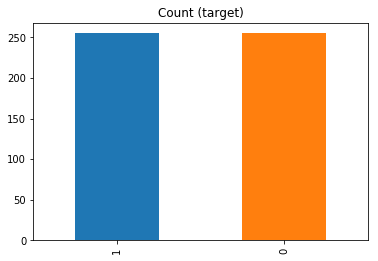

In [20]:
df_class_1_under = df_class_1.sample(count_class_0)
data_bal = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(data_bal["y_avgtone"].value_counts())

data_bal["y_avgtone"].value_counts().plot(kind='bar', title='Count (target)');

In [21]:
# Event Code Classification
# X = token.texts_to_matrix(data_new["text"])
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_counts = count_vect.fit_transform(data_bal["text"])
X_tfidf = tfidf_transformer.fit_transform(X_counts)

y = data_bal["y_eventcode"]

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size= 0.2)

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_train_predicted = nb.predict(X_train)
y_test_predicted = nb.predict(X_test)

train_accuracy = metrics.accuracy_score(y_train, y_train_predicted)
test_accuracy = metrics.accuracy_score(y_test, y_test_predicted)

print("Train Accuracy = " + str(train_accuracy))
print("Test Accuracy = " + str(test_accuracy))

Train Accuracy = 0.8504901960784313
Test Accuracy = 0.39215686274509803


In [22]:
svm_clf = svm.SVC(kernel = "linear")
svm_clf.fit(X_train, y_train)

y_train_predicted = svm_clf.predict(X_train)
y_test_predicted = svm_clf.predict(X_test)

train_accuracy = metrics.accuracy_score(y_train, y_train_predicted)
test_accuracy = metrics.accuracy_score(y_test, y_test_predicted)

print("Train Accuracy = " + str(train_accuracy))
print("Test Accuracy = " + str(test_accuracy))

Train Accuracy = 0.9068627450980392
Test Accuracy = 0.4019607843137255


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data_bal["y_avgtone"], test_size= 0.2)

start = time.time()

nb = MultinomialNB()
nb.fit(X_train, y_train)
scores = cross_val_score(nb, X_train, y_train, cv=10)

y_train_predicted = nb.predict(X_train)
y_test_predicted = nb.predict(X_test)

print(time.time() - start)

print("Accuracy: %0.6f (+/- %0.6f)" % (scores.mean(), scores.std() * 2))
train_accuracy = metrics.accuracy_score(y_train, y_train_predicted)
test_accuracy = metrics.accuracy_score(y_test, y_test_predicted)

print("Train Accuracy = " + str(train_accuracy))
print("Test Accuracy = " + str(test_accuracy))

0.09225606918334961
Accuracy: 0.659948 (+/- 0.156463)
Train Accuracy = 0.8872549019607843
Test Accuracy = 0.6470588235294118


In [45]:
start = time.time()
svm_clf = svm.SVC(kernel = "linear", random_state=0)
svm_clf.fit(X_train, y_train)
scores = cross_val_score(svm_clf, X_train, y_train, cv=10)

y_train_predicted = svm_clf.predict(X_train)
y_test_predicted = svm_clf.predict(X_test)

print(time.time() - start)
print("Accuracy: %0.6f (+/- %0.6f)" % (scores.mean(), scores.std() * 2))
train_accuracy = metrics.accuracy_score(y_train, y_train_predicted)
test_accuracy = metrics.accuracy_score(y_test, y_test_predicted)

print("Train Accuracy = " + str(train_accuracy))
print("Test Accuracy = " + str(test_accuracy))

2.7851548194885254
Accuracy: 0.701536 (+/- 0.152561)
Train Accuracy = 0.9534313725490197
Test Accuracy = 0.7058823529411765


In [47]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(classification_report(y_test, y_test_predicted))
print(confusion_matrix(y_test, y_test_predicted))

             precision    recall  f1-score   support

          0       0.67      0.73      0.70        48
          1       0.74      0.69      0.71        54

avg / total       0.71      0.71      0.71       102

[[35 13]
 [17 37]]


In [49]:
from sklearn.tree import DecisionTreeClassifier
import time
start = time.time()
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
scores = cross_val_score(dt, X_train, y_train, cv=10)

y_train_predicted = dt.predict(X_train)
y_test_predicted = dt.predict(X_test)
print(time.time() - start)

print("Accuracy: %0.6f (+/- %0.6f)" % (scores.mean(), scores.std() * 2))
train_accuracy = metrics.accuracy_score(y_train, y_train_predicted)
test_accuracy = metrics.accuracy_score(y_test, y_test_predicted)
print(scores.mean())
print("Train Accuracy = " + str(train_accuracy))
print("Test Accuracy = " + str(test_accuracy))

1.1284079551696777
Accuracy: 0.625563 (+/- 0.171310)
0.6255632984901278
Train Accuracy = 0.9681372549019608
Test Accuracy = 0.6274509803921569


In [50]:
from sklearn.ensemble import RandomForestClassifier
start = time.time()
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
scores = cross_val_score(rf, X_train, y_train, cv=10)

y_train_predicted = rf.predict(X_train)
y_test_predicted = rf.predict(X_test)
print(time.time() - start)

print("Accuracy: %0.6f (+/- %0.6f)" % (scores.mean(), scores.std() * 2))
train_accuracy = metrics.accuracy_score(y_train, y_train_predicted)
test_accuracy = metrics.accuracy_score(y_test, y_test_predicted)

print("Train Accuracy = " + str(train_accuracy))
print("Test Accuracy = " + str(test_accuracy))

1.0343620777130127
Accuracy: 0.632819 (+/- 0.178147)
Train Accuracy = 0.9411764705882353
Test Accuracy = 0.6176470588235294


Dengan pembersihan data, ditemukan hasil klasifikasi event code masih overfitting. Hal ini menunjukkan data yang dimiliki kurang.

Namun untuk kasus sentiment analysis menggunakan avgtone, ditemukan hasilnya cukup menjanjikan. Tidak ada overfitting.

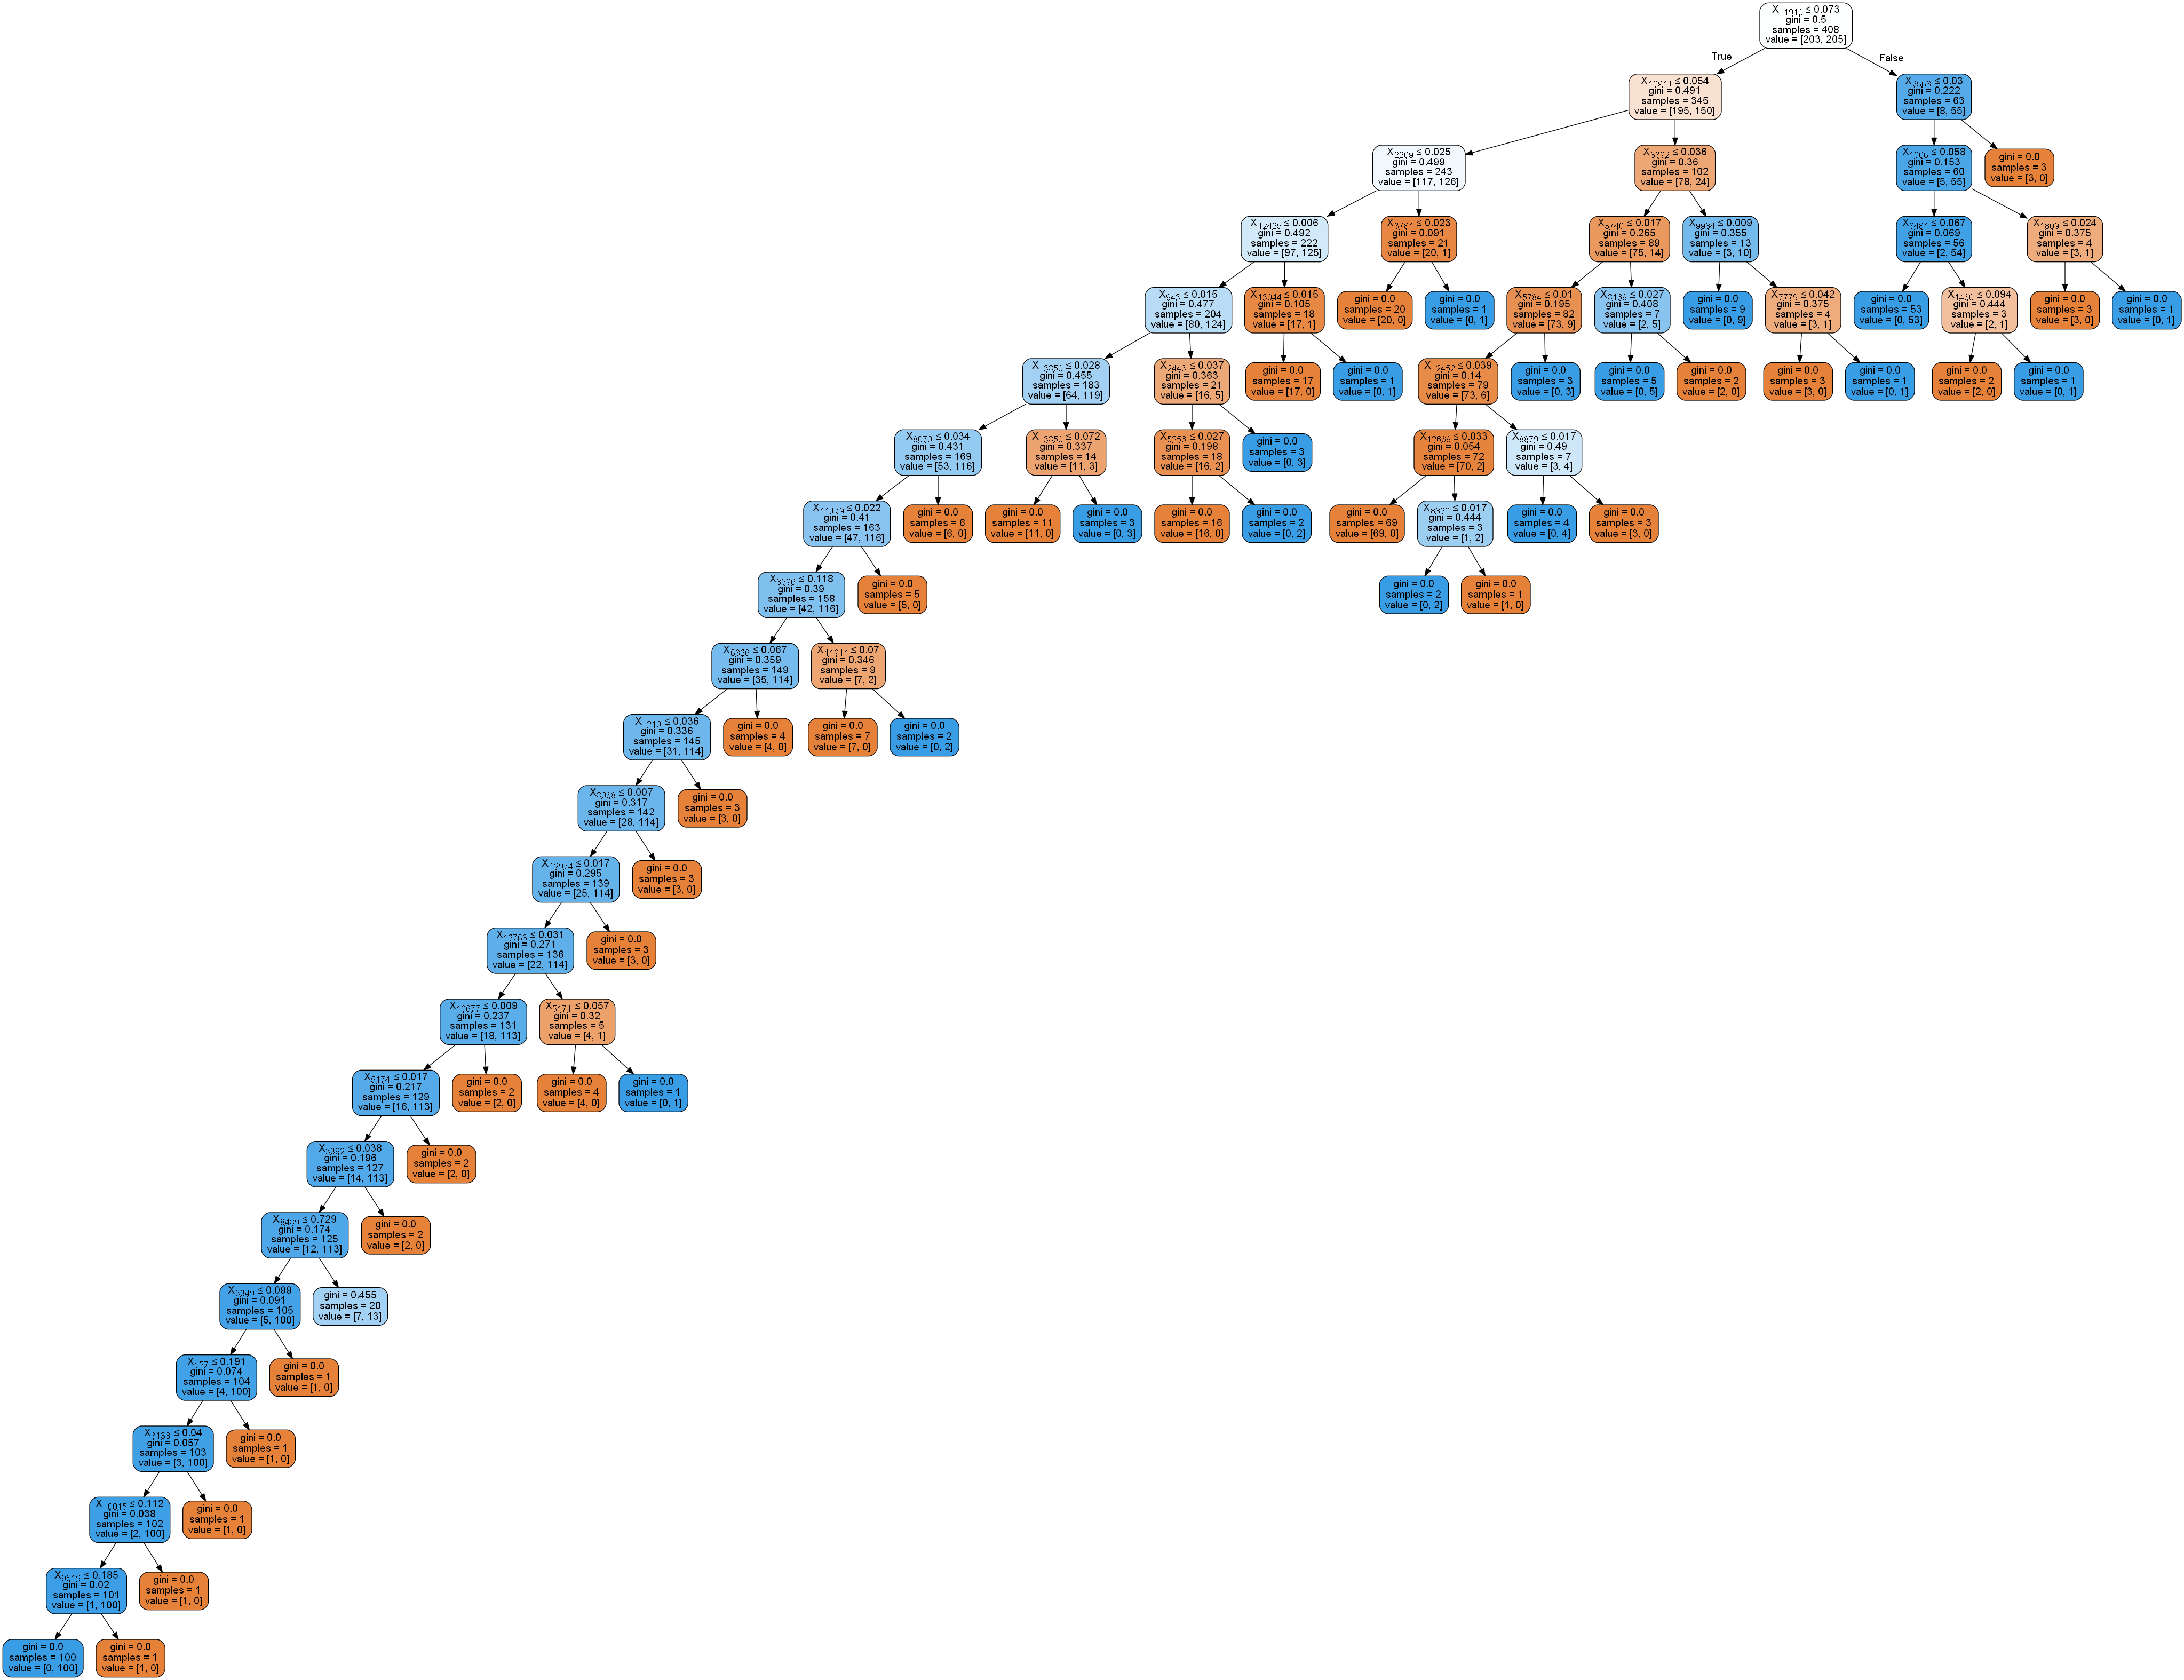

In [27]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Clustering

In [1]:
import numpy as np
import pandas as pd
import nltk
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

In [7]:
# hai = text[1].encode('utf-8', 'ignore').decode('utf-8')
# hai = [word for word in text[1].split(" ") if word.isalpha()]
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(txt):
    unnecessary = ['indonesia','indonesian','startup','startups','said','company','companies','business','businesses', 'digital']
    txt_c = re.sub(r'[^A-Za-z0-9]+', ' ', txt)
    txt_c = txt_c.split(" ")
    words = [w for w in txt_c if not w in stop_words]
    words_ne = [a for a in words if not a.lower() in unnecessary]
    txt_c = " ".join(words_ne)
    txt_c = txt_c.lower()
    return txt_c

text_clear = text.apply(clean_text)
text_clear.head()

0.0    f2pool founder crypto wallet raises 13 million...
1.0    how ritesh agarwal oyo scaled great wall china...
2.0    minister communication information aims have 1...
4.0    customer connect whole new ball game in last s...
5.0    15 singapore join collaborate batam nongsa par...
dtype: object

In [8]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [9]:
totalvocab_tokenized = []
for i in text_clear:
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [10]:
totalvocab_tokenized = pd.Series(totalvocab_tokenized)

In [11]:
print (len(totalvocab_tokenized))


347407


In [12]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized})

# vocab_frame = vocab_frame.replace(unecessary,'')

In [13]:
len(vocab_frame)

347407

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(stop_words='english')

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=50000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_only, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(text_clear)

print(tfidf_matrix.shape)

Wall time: 5.44 s
(1093, 91)


In [15]:
terms = tfidf_vectorizer.get_feature_names()

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

### KMeans Analysis

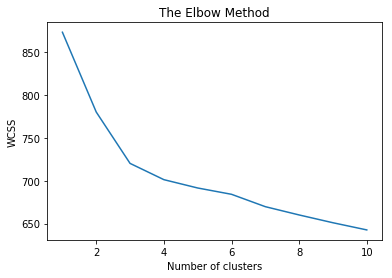

In [17]:
# PLOT ELBOW, Source code ini paling berfungsi untuk TFIDF

X = tfidf_matrix

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=100,n_init=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

In [18]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters,init='k-means++',max_iter=100,n_init=1)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 194 ms


In [19]:
clustered_df = df_text.copy(deep=True)
clustered_df['CLUSTERS'] = clusters
clustered_df["ARTICLEURL"] = clustered_df["ARTICLEURL"].apply(clean_text)
clustered_df["ARTICLETITLE"] = clustered_df["ARTICLETITLE"].apply(clean_text)
clustered_df.head()

,ARTICLEURL,ARTICLETITLE,CLUSTERS
0.0,cobo beijing based cryptocurrency wallet close...,f2pool founder crypto wallet raises 13 million,0
1.0,bengaluru when hotel chain oyo decided expand ...,how ritesh agarwal oyo scaled great wall china,0
2.0,listen jakarta nnc minister communication inf...,minister communication information aims have 1...,0
4.0,in last six months employees razorpay sharpene...,customer connect whole new ball game,0
5.0,listen jakarta nnc despite inaugurated foreig...,15 singapore join collaborate batam nongsa park,0


In [20]:
title = clustered_df['ARTICLETITLE']

In [21]:
clustered_df['CLUSTERS'].value_counts()

0    684
1    265
2    144
Name: CLUSTERS, dtype: int64

In [22]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 asia
 million
 online
 funding
 market
 singapore
 new
 tech
 platform
 jakarta
Cluster 1:
 commerce
 e commerce
 e
 online
 com
 government
 market
 billion
 percent
 china
Cluster 2:
 fintech
 financial
 bank
 services
 technology
 industry
 sector
 new
 payment
 development


In [23]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [24]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [26]:
#set up colors per clusters using a dict
cluster_colors = {0: '#163ea4', 1: '#66a61e', 2: '#e7298a'} #3: '#e7298a', 4: '#d95f02', 5: '#1b9e77'
# cluster_colors = {0: '#163ea4', 1: '#66a61e', 2: '#e7298a', 3: '#e7298a', 4: '#d95f02'}#, 5: '#1b9e77'

#set up cluster names using a dict
cluster_names = {0: 'Asia, Million, Funding, Market, Singapore', 
                 1: 'Commerce, E-Commerce, Online, Market, Percent',
                 2: 'Fintech, Financial, Technology, Bank, Services, Industry'
                 }
# cluster_names = {0: 'Platform, online, mobile', 
#                  1: 'Fintech, Financial, Technology, Bank, Services, Industry',
#                  2: 'Commerce, E-Commerce, Online, Market, Percent',
#                  3: 'Asia, Million, Funding, Market, Singapore',
#                 4: 'Jakarta, People, New, Local, World'}

In [27]:
%matplotlib inline

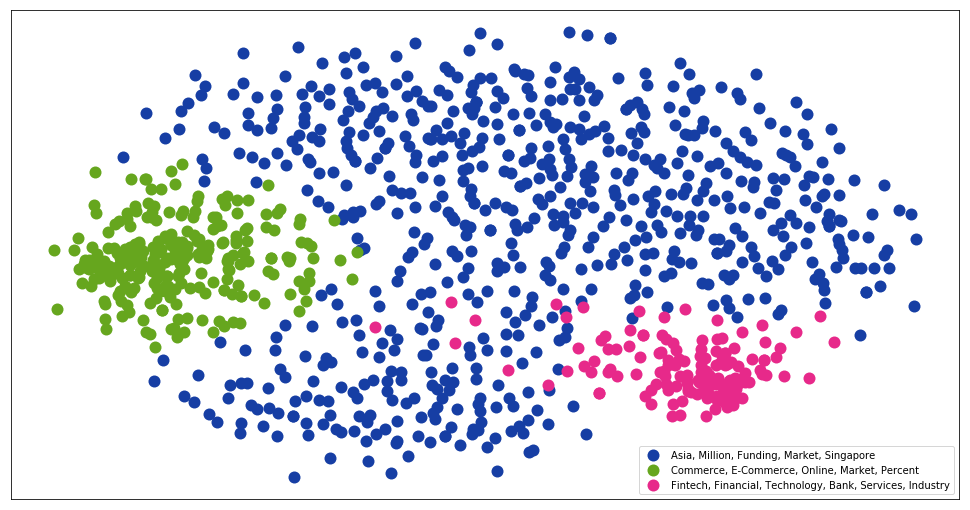

In [28]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=title)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom= False,      # ticks along the bottom edge are off
        top= False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

# MILESTONE 5 - Penarikan Kesimpulan

Pada Milestone 5 akan dilakukan pembahasan untuk setiap Research Question yang telah dirumuskan sebelumnya. Research Question dari project ini adalah sebagai berikut:
1. Event seputar apa saja yang sedang ngetren di Indonesia?
2. Apa saja hal menarik yang di bahas di dunia internasional terkait start up di Indonesia?
3. Bagaimana persepsi dunia internasional tentang startup Indonesia? 
4. Negara apa saja yang berpengaruh pada startup Indonesia?

## Event seputar apa saja yang sedang menjadi tren tentang startup Indonesia?

Untuk menjawab pertanyaan ini, kami menggunakan program Tableau Public dengan data yang sudah dibersihkan.

In [87]:
Image(url= "https://i.ibb.co/hFgmRss/eventcode.png")

Gambar Event Code yang terdapat di Lampiran dan link di atas menunjukkan kode berita apa saja yang banyak diberitakan mengenai start-up Indonesia. Kode berita paling banyak diberitakan tentang startup Indonesia antara lain adalah No. 10 “Make Statement” sebanyak 122 berita, No. 71 “Provide Economic Aid” sebanyak 117 berita, dan No. 51 “Praise or Endorse” sebanyak 113 berita. Untuk kode event no. 10 mengindikasikan bahwa berita tersebut berisikan pemberian pernyataan secara verbal maupun nonverbal tetapi tidak dapat digambarkan secara spesifik pernyataan tersebut mengenai hal apa. Kode event no. 71 mengindikasikan berita tentang pemberian bantuan finansial berupa investasi pihak dalam negeri maupun luar negeri kepada startup di Indonesia. Event selanjutnya no. 51 mengindikasikan tentang pemberian support, pemberian penghargaan, maupun persetujuan kebijakan baik dalam negeri maupun luar negeri, kepada startup di Indonesia. 

## Apa saja hal menarik yang dibahas di dunia internasional terkait start up Indonesia?

### Berdasarkan Clustering

In [22]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 asia
 million
 online
 funding
 market
 singapore
 new
 tech
 platform
 jakarta
Cluster 1:
 commerce
 e commerce
 e
 online
 com
 government
 market
 billion
 percent
 china
Cluster 2:
 fintech
 financial
 bank
 services
 technology
 industry
 sector
 new
 payment
 development


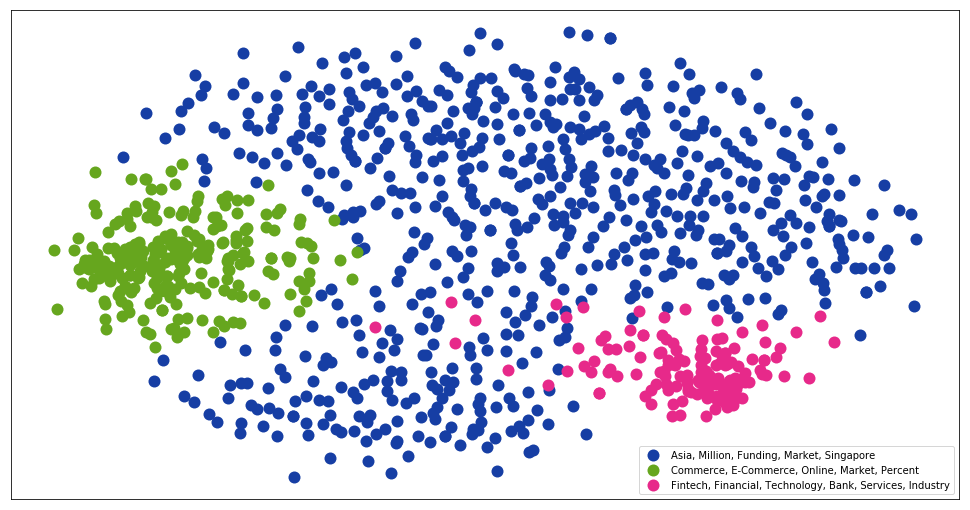

In [28]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=title)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom= False,      # ticks along the bottom edge are off
        top= False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

Gambar di atas merupakan hasil dari clustering kata pada berita startup Indonesia tahun 2014-2018 yang dianalisis dengan menggunakan K-means k = 3. Dari hasil clustering tersebut dapat diketahui hal menarik yang dibahas dunia Internasional mengenai start-up Indonesia. Klaster ke-0 berisi hal yang bersifat general yaitu Asia, Million, Funding, Market, dan Singapore. Klaster 1 dan Klaster 2 lebih spesifik dibandingkan dengan klaster 0, dimana klaster 1 berisi hal yang merujuk pada e-commerce dan klaster 2 berisi hal yang merujuk pada financial technology (fintech).

### Berdasarkan Word Cloud

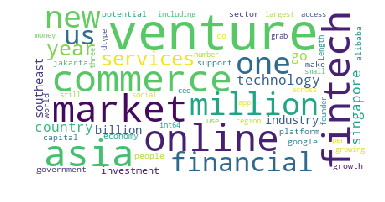

In [14]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(freq))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Berdasarkan wordcloud di atas, dapat terlihat hal yang sering dibicarakan oleh dunia Internasional tentang startup di Indonesia. Pada wordcloud, hal yang menarik yang sering dibicarakan dunia internasional tentang startup Indonesia ditandai dengan ukuran tulisan yang besar diantaranya adalah asia, e-commerce, fintech, market, dan online. Jika dibandingkan dengan bagian sebelumnya, hasil dari wordcloud menunjukkan hal yang serupa dengan hasil clustering, yaitu asia, e-commerce, dan fintech. 

## Bagaimana persepsi dunia internasional tentang startup Indonesia?

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.ibb.co/x6JMwvs/Average-graph.png")

Persepsi negara lain tentang startup Indonesia dapat dilihat dari nada berita mengenai pemberitaan startup Indonesia. Jika dilihat dari gambar grafik average tone tahun 2014 hingga 2018, rata-rata nilai pemberitaan bernilai positif. Namun, jika dibandingkan dengan rentang nilai tone yang bernilai -100 hingga 100, dapat dikatakan bahwa persepsi dari negara lain terhadap startup di Indonesia cenderung netral. Hal tersebut dapat dilihat dari nilai tertinggi dari average tone yang terdapat pada tahun 2014 di Bulan Agustus yang hanya bernilai 4,386 atau 4,386% dari rentang nilai tone berita. Pada milestone 4 bagian visualisasi, terdapat peta negara beserta tone berita startup Indonesia dimana nada pemberitaan startup Indonesia tertinggi berasal dari Negara Kanada, sedangkan untuk nada pemberitaan terendah berasal dari Negara Pakistan.

## Negara apa saja yang berpengaruh pada startup Indonesia?

### IDN sebagai Actor 1
Berikut ini merupakan Actor2 yang menjadi pihak yang terdampak dari event/berita yang dilakukan oleh Indonesia (Actor1).

Text(0,0.5,'Jumlah Berita')

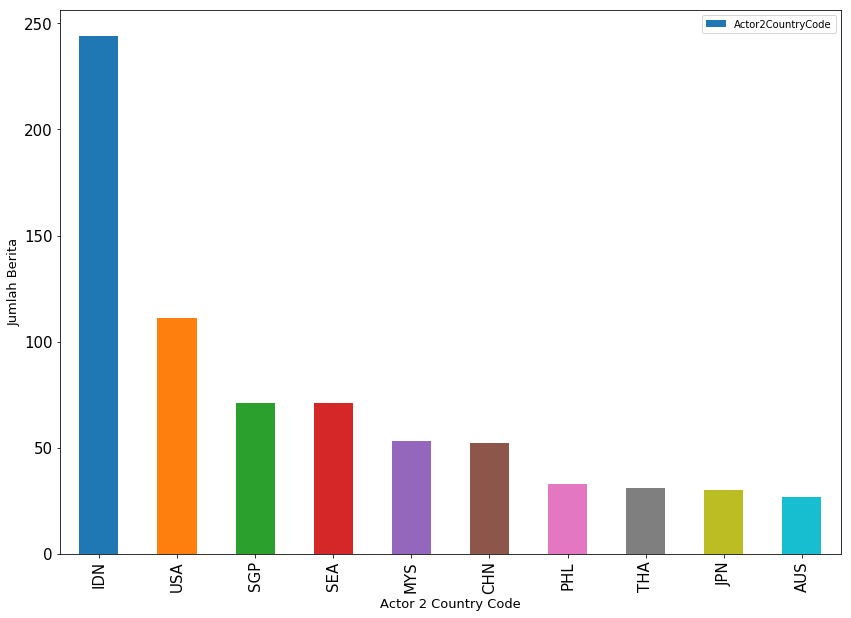

In [27]:
plt.figure(figsize=(14,10))
ax = act1ind_act2.value_counts().head(10)
ax = ax.plot(kind='bar', title ="", legend=True, fontsize=15)
ax.set_xlabel("Actor 2 Country Code", fontsize=13)
ax.set_ylabel("Jumlah Berita", fontsize=13)

Grafik di atas menunjukkan Actor 2 atau pihak yang dipengaruhi oleh IDN sebagai Actor 1. Dari grafik didapatkan bahwa Indonesia sebagai Actor 1 memberikan dampak terbanyak pada Indonesia sendiri. Selanjutnya, Indonesia paling banyak memengaruhi empat negara lainnya yaitu Amerika Serikat (USA), Asia Tenggara (SEA), Singapura (SGP) dan Malaysia (MYS). Lima negara lainnya yang ikut terdampak adalah China, Filipina, Thailand, dan Australia. 

### IDN sebagai Actor 2
Berikut ini merupakan Actor1 yang menjadi pihak yang memberikan dampak dari event/berita yang dilakukan oleh Indonesia (Actor2).

Text(0,0.5,'Jumlah Berita')

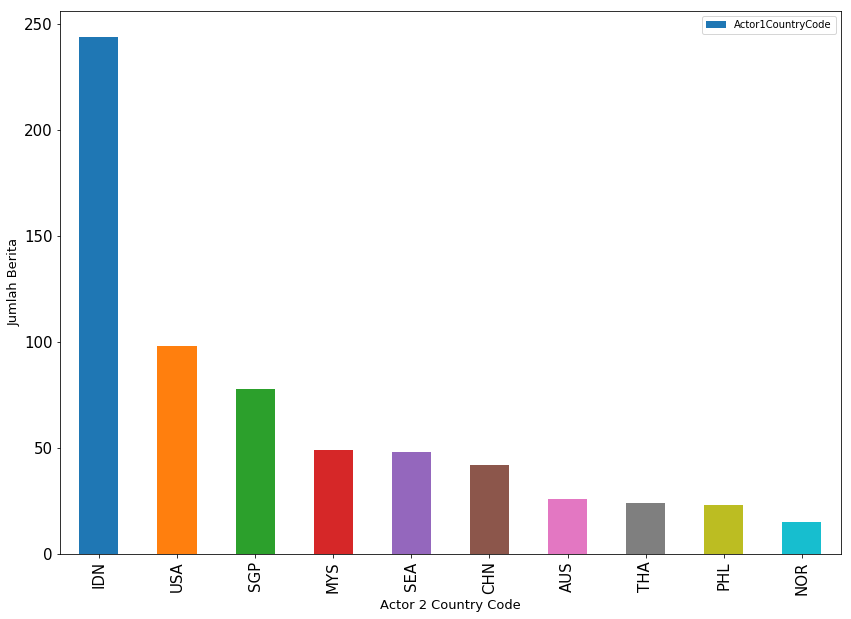

In [29]:
plt.figure(figsize=(14,10))
ax = act2ind_act1.value_counts().head(10)
ax = ax.plot(kind='bar', title ="", legend=True, fontsize=15)
ax.set_xlabel("Actor 1 Country Code", fontsize=13)
ax.set_ylabel("Jumlah Berita", fontsize=13)

Grafik di atas menunjukkan Actor 1 atau pihak yang memengaruhi IDN sebagai Actor 2. Dari grafik didapatkan bahwa Indonesia sebagai Actor 2 merupakan pihak yang dipengaruhi terbanyak atas pemberitaan Indonesia sendiri. Selanjutnya, Indonesia paling banyak dipengaruhi oleh Amerika Serikat (USA), Singapura (SGP), Malaysia (MYS) dan Asia Tenggara (SEA). Lima negara lainnya yang memberikan pengaruh pada Indonesia adalah China, Australia, Thailand, Filipina, dan Norwegia. 

Jika dibandingkan data pada Indonesia sebagai Actor 1 maupun Actor 2, negara yang memberikan pengaruh pada startup Indonesia tidak memiliki perbedaan yang signifikan. Rata-rata negara yang memiliki hubungan timbal balik (memengaruhi dan dipengaruhi) dengan Indonesia dalam hal startup adalah Amerika Serikat, Singapura, Malaysia, China, Australia, Thailand, dan Filipina. Untuk negara yang hanya dipengaruhi oleh Indonesia adalah Jepang dan negara yang memengaruhi Indonesia adalah Norwegia. 